# SKLearn Models for RDPML

## Index

[Imports](#Imports)

[RDP Predicitons](#RDPs-performance-as-baseline)

[Prediction Models](#Prediction-Models)

[Loading in the Unseen Data Set](#Loading-in-the-Unseen-Data-Set)

[Logistic Regression](#Logistic-Regression)

[Gradient Booster Classifier LightGBM Style](#Gradient-Booster-Classifier-LightGBM-Style)

[Random Forest](#Random-Forest)

[Gaussian Naive Bayes](#Gaussian-Naive-Bayes)

[Voting Ensemble of Multiple Algorithms](#Voting-Ensemble-of-Multiple-Algorithms)

[Nearest Neighbours](#Nearest-Neighbours)

## Imports

In [1]:
import datetime
import os
import numpy as np
import pandas as pd
from pathlib import PurePath
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
import tools
from tools import class_report, ingestor
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import re

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import textwrap
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score

from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import textwrap

import matplotlib.pyplot as plt
import numpy as np

## Dataset Imports

Only useful once the pipelines have been run from raw data generation through recombinant/parent/parent selection and RDP5 CL run.

Datasets available on request from Josh Cullinan (clljos00@myuct.ac.za)

In [2]:
#Used to create a single ml_input file from the output pipelines.
if not (os.path.isfile(PurePath('output_test/ml_input.csv'))):
    XML_1 = pd.read_csv("output_test/ml_input_XML-1.txt", sep = ',', header=0)
    XML_2 = pd.read_csv("output_test/ml_input_XML-2.txt", sep = ',', header=0)
    XML_3 = pd.read_csv("output_test/ml_input_XML-3.txt", sep = ',', header=0)
    XML_4 = pd.read_csv("output_test/ml_input_XML-4.txt", sep = ',', header=0)
    XML_5 = pd.read_csv("output_test/ml_input_XML-5.txt", sep = ',', header=0)
    
    ml_input = pd.concat([XML_1, XML_2, XML_3, XML_4,XML_5], ignore_index = True)
    ml_input.to_csv("output_test/ml_input.txt", sep=",", index=False)

In [3]:
# Check whether the test and train datasets have been created yet, otherwise ingest and save to .csv
if not (os.path.isfile(PurePath('dataParsed_test/Train.csv')) and os.path.isfile(PurePath('dataParsed_test/Test.csv'))):
    allData = pd.read_csv('output_test/ml_input.txt', sep=",")
    Train, Test = train_test_split(allData, test_size=10002, random_state=42, shuffle=False) #Shuffle is false to preserve triplet structure.
    Train.to_csv("dataParsed_test/Train.csv", sep=",", index=False)
    Test.to_csv("dataParsed_test/Test.csv", sep=",",  index=False)

In [4]:
# Check whether holdout test data has been ingested yet, otherwise import and save to .csv
if not (
    os.path.isfile(
        "dataParsed_test/Unseen.csv")
):

    Unseen = pd.read_csv('output_test/ml_input_UnseenTestSet.txt', sep=",", index_col=False)
    Unseen.to_csv("dataParsed_test/Unseen.csv", sep=",",index=False)

### Figures for RDP evaluation

In [5]:
def StdConfMatrix(y_true, y_pred, normalise=None, format='.6g', figure_number=None):
    # Create figure
    fig = plt.figure(figsize=(9, 9))
    
    if figure_number is not None:
        # Create a small subplot for the figure number (top left)
        ax_number = fig.add_axes([0.01, 0.92, 0.01, 0.002])  # [left, bottom, width, height]
        ax_number.axis('off')  # Hide axis
        ax_number.text(0, 0.5, f'{figure_number}',
                      fontsize=14,
                      fontweight='semibold',
                      style='italic',
                      horizontalalignment='left',
                      verticalalignment='center')
    
    # Create main subplot for the confusion matrix
    ax_main = fig.add_axes([0.1, 0.1, 0.85, 0.85])  # [left, bottom, width, height]
    
    # Create and display confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true=y_true,
        y_pred=y_pred,
        normalize=normalise,
        cmap='PuBu',
        values_format=format,
        display_labels=["Parent", "Recombinant"],
        text_kw={'size': 14},
        colorbar=False,
        ax=ax_main  # Pass the main axis to plot on
    )
    
    plt.colorbar(disp.im_, ax=ax_main, shrink=0.8, pad=0.05)

    # Customize the plot
    ax_main.set_title('Confusion Matrix', pad=20, size=18)  # Title Size
    
    # Adjust label sizes
    ax_main.set_xlabel('Predicted', fontsize=14)  # X-axis label size
    ax_main.set_ylabel('True', fontsize=14)       # Y-axis label size
    
    # Adjust tick sizes, rotation, and padding
    ax_main.tick_params(axis='x', labelsize=12, pad=10)  # x-axis padding
    ax_main.tick_params(axis='y', labelsize=12, pad=10)  # y-axis padding
    
    # Rotate and align y-axis labels
    ax_main.set_yticklabels(
        ax_main.get_yticklabels(),
        rotation=90,
        va='center',  # Vertical alignment
        ha='center'   # Horizontal alignment
    )
    
    # Return the display object and main axis for further customization if needed
    return disp, ax_main

def StdRocCurve(y_true, y_probs1, y_probs2=None, auc_decimals=4, model_names=["Model 1", "Model 2"], figure_number=None):
    # Create figure
    fig = plt.figure(figsize=(9, 9))
    
    if figure_number is not None:
        # Create a small subplot for the figure number (top left)
        ax_number = fig.add_axes([0.01, 1.02, 0.01, 0.002])  # [left, bottom, width, height]
        ax_number.axis('off')  # Hide axis
        ax_number.text(0, 0.5, f'{figure_number}', 
                      fontsize=14,
                      fontweight='semibold',
                      style='italic',
                      horizontalalignment='left',
                      verticalalignment='center')
    
    # Create main subplot for the ROC curve
    ax_main = fig.add_axes([0.1, 0.1, 0.85, 0.85])  # [left, bottom, width, height]
    
    # Calculate ROC curve points and AUC for first model
    fpr1, tpr1, _ = roc_curve(y_true, y_probs1)
    auc1 = roc_auc_score(y_true, y_probs1)
    
    # Plot first ROC curve in blue
    disp1 = RocCurveDisplay(
        fpr=fpr1,
        tpr=tpr1,
        roc_auc=auc1,
        estimator_name=f"{model_names[0]} (AUC = {auc1:.{auc_decimals}f})"
    )
    
    disp1.plot(
        ax=ax_main,
        plot_chance_level=True,
        color=plt.cm.PuBu(0.8)
    )
    
    # If second set of probabilities is provided, plot second ROC curve
    if y_probs2 is not None:
        fpr2, tpr2, _ = roc_curve(y_true, y_probs2)
        auc2 = roc_auc_score(y_true, y_probs2)
        
        # Plot second ROC curve in grey
        disp2 = RocCurveDisplay(
            fpr=fpr2,
            tpr=tpr2,
            roc_auc=auc2,
            estimator_name=f"{model_names[1]} (AUC = {auc2:.{auc_decimals}f})"
        )
        
        disp2.plot(
            ax=ax_main,
            plot_chance_level=False,
            color='grey'
        )
    
    plt.grid(True)
    ax_main.set_xlim([0.0, 1.0])
    ax_main.set_ylim([0.0, 1.0])
    
    # Adjust label sizes
    ax_main.set_xlabel('False Positive Rate', fontsize=14)
    ax_main.set_ylabel('True Positive Rate', fontsize=14)
    
    legend_text = [f"{model_names[i]} (AUC = {auc:.{auc_decimals}f})" for i, auc in enumerate([auc1] + ([auc2] if y_probs2 is not None else []))] + ["Chance level (AUC = 0.5)"]
    # Customize legend
    ax_main.legend(
        legend_text,
        fontsize=12,
        loc='lower right'
    )
    
    return fig, ax_main

# RDPs performance as baseline

In [6]:
# Input Data from saved File
X_unseen = pd.read_csv("dataParsed_test/Unseen.csv", index_col=False, sep=",")

# Create response variables
y_unseen = X_unseen.pop("is_recombinant").astype(np.int64)

In [7]:
rdp_consensus = X_unseen.loc[:, ['Consensus(A:2)']]#,'Consensus(A:0)', 'Consensus(A:1)']] #
probs = rdp_consensus.to_numpy()
len(probs)

16617

In [8]:
# Makes dependent decisions by taking the highest value from the decision tree, indicating that that sequence has the highest support.
dep_preds = pd.Series()
print(dep_preds.head())
for i in range(0, len(probs), 3):
    triplet = pd.Series(data = [probs[i], probs[i+1], probs[i+2]])
    indx = triplet.idxmax()
    new = pd.Series([0, 0, 0], index=[i, i+1, i+2])
    new.loc[i+indx] = 1
    dep_preds = pd.concat([dep_preds, new], ignore_index=False)

Series([], dtype: object)


/tmp/ipykernel_124812/450470430.py:9: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  dep_preds = pd.concat([dep_preds, new], ignore_index=False)


In [9]:
# Save the dependent decision for use in graphs later on.
# dep_preds.to_csv('models_test/RDPdep_preds.csv', sep=",", index=False)

In [10]:
# Load in these predictions if needed.
# dep_preds = pd.read_csv('models_test/RDPdep_preds.csv', sep=",")

Dependant predictions on the 'Unseen' test set
              precision    recall  f1-score   support

      Parent     0.8258    0.8258    0.8258     11078
 Recombinant     0.6516    0.6516    0.6516      5539

    accuracy                         0.7677     16617
   macro avg     0.7387    0.7387    0.7387     16617
weighted avg     0.7677    0.7677    0.7677     16617



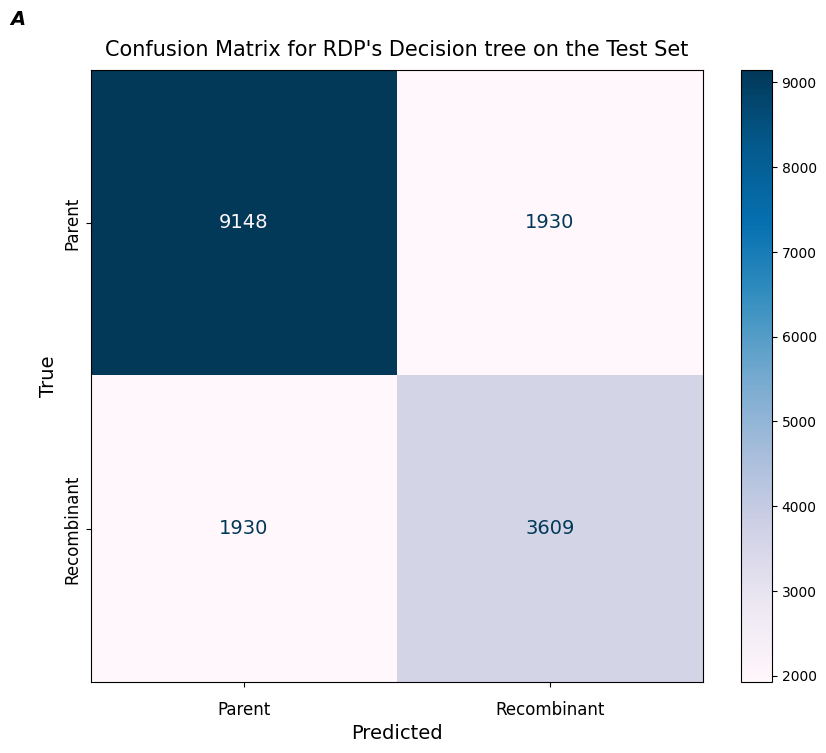

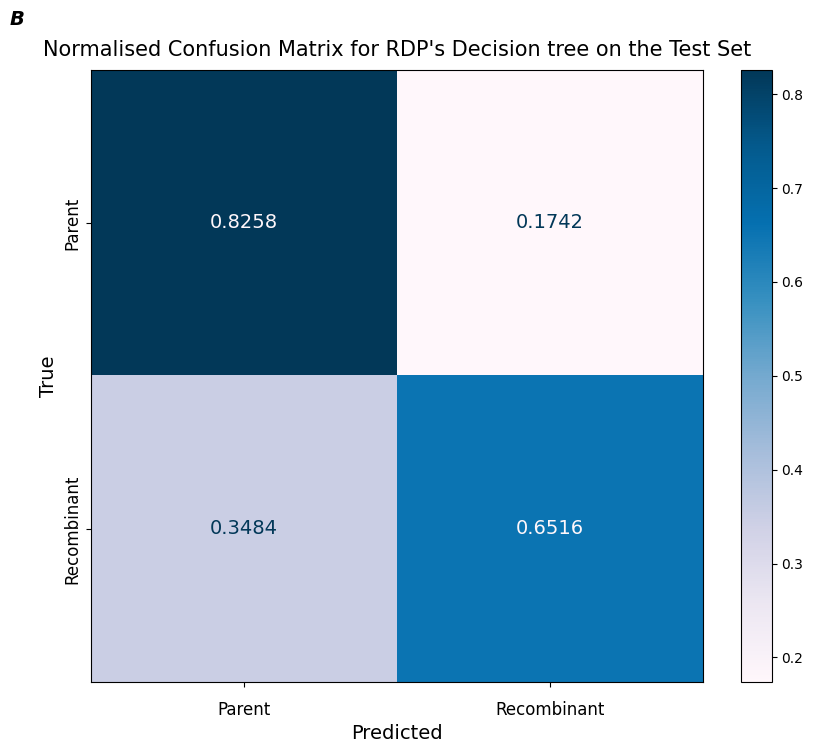

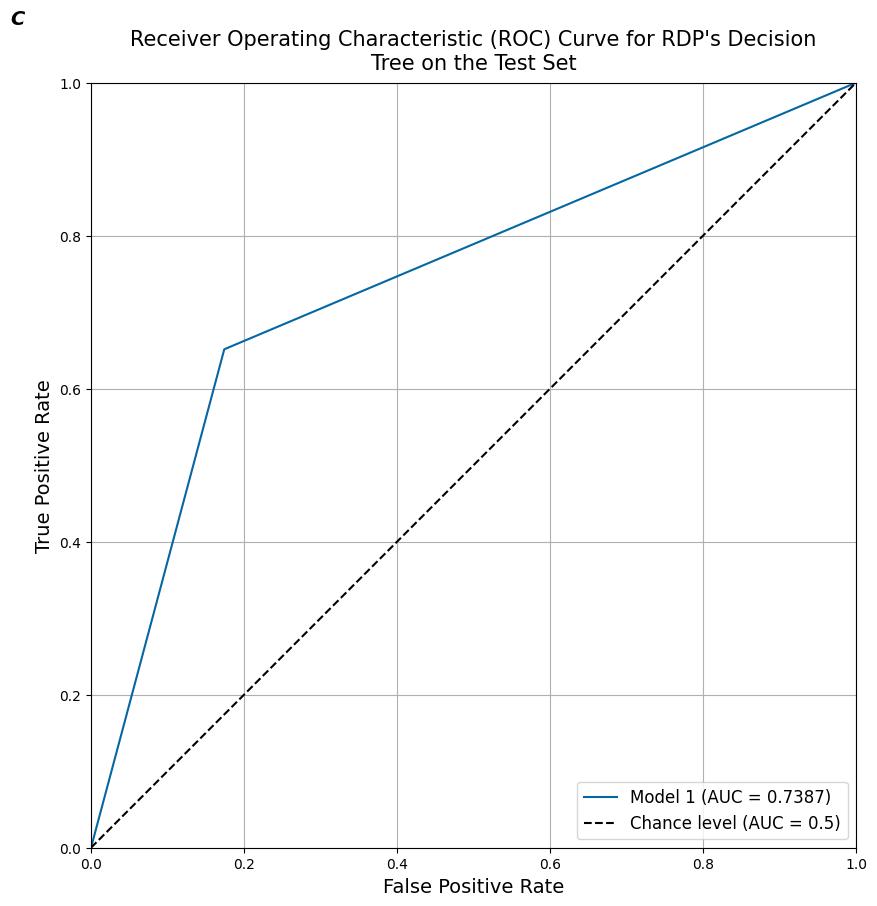

In [11]:
print("Dependant predictions on the 'Unseen' test set")

#Classification Report
class_report(y_true=y_unseen, y_preds=dep_preds)

# Use standard confusion matrix function 
disp, ax = StdConfMatrix(y_unseen, dep_preds, figure_number='A')
title = "Confusion Matrix for RDP's Decision tree on the Test Set"
wrapped_title = textwrap.fill(title, width=70)
ax.set_title(wrapped_title, pad=10, size=15) 
plt.show()

# Use standard confusion matrix function 
disp, ax = StdConfMatrix(y_unseen, dep_preds, normalise='true', format='.4f', figure_number='B')
title = "Normalised Confusion Matrix for RDP's Decision tree on the Test Set" 
wrapped_title = textwrap.fill(title, width=70)
ax.set_title(wrapped_title, pad=10, size=15) 
plt.show()

disp, ax = StdRocCurve(y_unseen, dep_preds, figure_number='C')
title = "Receiver Operating Characteristic (ROC) Curve for RDP's Decision Tree on the Test Set"
wrapped_title = textwrap.fill(title, width=68)
ax.set_title(wrapped_title, pad=10, size=15) 
plt.show()

# New Models Start Here

#### Input data

In [12]:
# Input Data from saved File
X_train = pd.read_csv('dataParsed_test/Train.csv', index_col=False)
X_test = pd.read_csv('dataParsed_test/Test.csv', index_col=False)
X_unseen = pd.read_csv("dataParsed_test/Unseen.csv", index_col=False)

#### Remove Consensus Metrics that RDP uses in it's calculations

In [13]:
#Drop Consensus metrics
colToDrop = ['Consensus(A:0)', 'Consensus(A:1)', 'Consensus(A:2)']
X_train = X_train.drop(columns=colToDrop)
X_test = X_test.drop(columns=colToDrop)
X_unseen = X_unseen.drop(columns=colToDrop)

# Rename Some features for ease of use later
def z(x): return x.replace("(", "").replace(")", "").replace(":", "_").replace(
    " ", "_")
X_train.columns = pd.Series(X_train.columns).apply(z)
X_test.columns = pd.Series(X_test.columns).apply(z)
X_unseen.columns = pd.Series(X_unseen.columns).apply(z)

In [14]:
# Create response variables
y_train = X_train.pop("is_recombinant").astype(np.int64)
y_test = X_test.pop("is_recombinant").astype(np.int64)
y_unseen = X_unseen.pop("is_recombinant").astype(np.int64)

print(f'Number of training samples: {X_train.shape[0]} \n')
print(f'Number of test samples: {X_test.shape[0]} \n')
print(f'Number of unseen samples: {X_unseen.shape[0]} \n')

Number of training samples: 464505 

Number of test samples: 10002 

Number of unseen samples: 16617 



### Dropping data with little/no variation

In [15]:
# Drop data with no variance i.e. all have the same value (typically 0) - won't contribute to learning
VT = VarianceThreshold()
X_vt = VT.fit(X_train)
variance_mask = X_vt.get_support()

print('\nDropping these features that do not show any variance:')
print(X_train.columns[~variance_mask].values)

X_train = pd.DataFrame(VT.transform(X_train),
                       columns=X_train.columns[variance_mask], index=X_train.index)
X_test = pd.DataFrame(VT.transform(X_test),
                      columns=X_test.columns[variance_mask], index=X_test.index)
X_unseen = pd.DataFrame(VT.transform(X_unseen),
                      columns=X_unseen.columns[variance_mask], index=X_unseen.index)

input_size =  len(X_train.columns)
print(f'\nKeeping these {input_size} features')
print(X_train.columns.values)


Dropping these features that do not show any variance:
['SRCompatFA' 'SRCompatSA' 'RCompatXFA' 'RCompatXSA' 'SetTot1_A']

Keeping these 32 features
['ListCorrA' 'SimScoreBA' 'SimScoreA' 'PhPrScoreA' 'PhPrScore2A'
 'PhPrScore3A' 'SubScoreA' 'SSDistA' 'OUIndexAA' 'SubPhPrScoreA'
 'SubScore2A' 'SubPhPrScore2A' 'RCompatA' 'RCompat2A' 'RCompat3A'
 'RCompat4A' 'RCompatSA' 'RCompatS2A' 'RCompatS3A' 'RCompatS4A'
 'RCompatCA' 'RCompatDA' 'TrpScoreA' 'BadDistsA' 'OUListA' 'ListCorr2A'
 'ListCorr3A' 'OuCheckA' 'SetTot0_A' 'RankFA_0' 'RankFA_1' 'dMaxA']


### Scale Inputs

In [16]:
# Scale inputs using standard scaler

Scale = StandardScaler()
Scale.fit(X_train)

X_train = pd.DataFrame(Scale.transform(X_train),
                       index=X_train.index,
                       columns=X_train.columns)
X_test = pd.DataFrame(Scale.transform(X_test),
                      index=X_test.index,
                      columns=X_train.columns)
X_unseen = pd.DataFrame(Scale.transform(X_unseen),
                      index=X_unseen.index,
                      columns=X_train.columns)


# Evaluation Metrics

#### Precision verus Recall
Precision is True positives/Selected elements.

Recall is the True Positives/Relevant elements.

F1 is the harmonic mean of precision and recall → F1 score aids with class imbalance as in this case. 

![Precision](figures/PrecisionRecall.png)

# Define Standard Figures

In [17]:
def StdRocCurve(y_true, y_probs_list, model_names=None, auc_decimals=4, figure_number=None, 
                colors=None, figsize=(9, 9)):
    """
    Plot multiple ROC curves on the same figure.
    
    Parameters:
    -----------
    y_true : array-like
        True binary labels
    y_probs_list : list of array-like
        List of probability estimates for each model
    model_names : list of str, optional
        Names for each model (default: ["Model 1", "Model 2", ..., "Model n"])
    auc_decimals : int, optional
        Number of decimals to display in AUC scores (default: 4)
    figure_number : int, optional
        Figure number to display in top left corner
    colors : list of str or None, optional
        Colors for each ROC curve. If None, uses a color map
    figsize : tuple, optional
        Figure size in inches (default: (9, 9))
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object
    ax_main : matplotlib.axes.Axes
        The main axes object
    """
    # Validate inputs
    if not isinstance(y_probs_list, list):
        y_probs_list = [y_probs_list]
    
    n_models = len(y_probs_list)
    
    # Set default model names if not provided
    if model_names is None:
        model_names = [f"Model {i+1}" for i in range(n_models)]
    elif len(model_names) != n_models:
        raise ValueError("Number of model names must match number of probability sets")
    
    # Set colors
    if colors is None:
        # Use colormap for multiple curves
        cmap = plt.get_cmap('Set2' if n_models <= 8 else 'tab20')# plt.cm.get_cmap('Set2' if n_models <= 8 else 'tab20')
        colors = [cmap(i/n_models) for i in range(n_models)]
    elif len(colors) != n_models:
        raise ValueError("Number of colors must match number of probability sets")
    
    # Create figure
    fig = plt.figure(figsize=figsize)
    
    # Add figure number if provided
    if figure_number is not None:
        ax_number = fig.add_axes([0.01, 1.02, 0.01, 0.002])
        ax_number.axis('off')
        ax_number.text(0, 0.5, f'{figure_number}',
                      fontsize=14,
                      fontweight='semibold',
                      style='italic',
                      horizontalalignment='left',
                      verticalalignment='center')
    
    # Create main subplot
    ax_main = fig.add_axes([0.1, 0.1, 0.85, 0.85])
    
    # Plot ROC curves for each model
    legend_text = []
    for i, (y_probs, model_name, color) in enumerate(zip(y_probs_list, model_names, colors)):
        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_true, y_probs)
        auc = roc_auc_score(y_true, y_probs)
        
        # Create display object
        disp = RocCurveDisplay(
            fpr=fpr,
            tpr=tpr,
            roc_auc=auc,
            estimator_name=f"{model_name} (AUC = {auc:.{auc_decimals}f})"
        )
        
        # Plot ROC curve
        disp.plot(
            ax=ax_main,
            plot_chance_level=(i == n_models-1),  # Only plot chance level for first curve
            color=color
        )
        
        # legend_text.append(f"{model_name} (AUC = {auc:.{auc_decimals}f})")
    
    # Add chance level to legend
    # legend_text.append("Chance level (AUC = 0.5)")
    
    # Customize plot
    plt.grid(True)
    ax_main.set_xlim([0.0, 1.0])
    ax_main.set_ylim([0.0, 1.0])
    
    # Set labels
    ax_main.set_xlabel('False Positive Rate', fontsize=14)
    ax_main.set_ylabel('True Positive Rate', fontsize=14)
    
    
    auc_scores = [roc_auc_score(y_true, y_probs) for y_probs in y_probs_list]
    # Then create legend text
    legend_text = [f"{name} (AUC = {auc:.{auc_decimals}f})" 
                for name, auc in zip(model_names, auc_scores)] + ["Chance level (AUC = 0.5)"]  
      
    # Customize legend
    ax_main.legend(
        legend_text,
        fontsize=12,
        loc='lower right'
    )
    
    return fig, ax_main


def StdConfMatrix(y_true, y_pred, normalise=None, format='.6g', figure_number=None):
    # Create figure
    fig = plt.figure(figsize=(9, 9))
    
    if figure_number is not None:
        # Create a small subplot for the figure number (top left)
        ax_number = fig.add_axes([0.01, 0.92, 0.01, 0.002])  # [left, bottom, width, height]
        ax_number.axis('off')  # Hide axis
        ax_number.text(0, 0.5, f'{figure_number}',
                      fontsize=14,
                      fontweight='semibold',
                      style='italic',
                      horizontalalignment='left',
                      verticalalignment='center')
    
    # Create main subplot for the confusion matrix
    ax_main = fig.add_axes([0.1, 0.1, 0.85, 0.85])  # [left, bottom, width, height]
    
    # Create and display confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true=y_true,
        y_pred=y_pred,
        normalize=normalise,
        cmap='PuBu',
        values_format=format,
        display_labels=["Parent", "Recombinant"],
        text_kw={'size': 14},
        colorbar=False,
        ax=ax_main  # Pass the main axis to plot on
    )
    
    plt.colorbar(disp.im_, ax=ax_main, shrink=0.8, pad=0.05)

    # Customize the plot
    ax_main.set_title('Confusion Matrix', pad=20, size=18)  # Title Size
    
    # Adjust label sizes
    ax_main.set_xlabel('Predicted', fontsize=14)  # X-axis label size
    ax_main.set_ylabel('True', fontsize=14)       # Y-axis label size
    
    # Adjust tick sizes, rotation, and padding
    ax_main.tick_params(axis='x', labelsize=12, pad=10)  # x-axis padding
    ax_main.tick_params(axis='y', labelsize=12, pad=10)  # y-axis padding
    
    # Rotate and align y-axis labels
    ax_main.set_yticklabels(
        ax_main.get_yticklabels(),
        rotation=90,
        va='center',  # Vertical alignment
        ha='center'   # Horizontal alignment
    )
    
    # Return the display object and main axis for further customization if needed
    return disp, ax_main

# Prediction Models

## Logistic Regression 

#### Calculate class weights
When treating the problem as binary "parent vs child" problem, it is often beneficial for the algorithm to weight certain classes stronger than others. In this case we have 1.5 times the number of parents to children (2 parents to one child); therefore, to enable the algorithm to weight children as "important" as the parents the class weights are set value to the parents less (0.75) and the children more (1.5).

In [68]:
#Calculate class Weights from Sklearn for training
cw = class_weight.compute_class_weight(class_weight='balanced',
                                       classes=np.unique(y_train),
                                       y=y_train.values)
class_weights = {0: cw[0], 1: cw[1]}
#class_weights = {0: 0.3, 1: 0.7}
print('class weights:', class_weights)

class weights: {0: np.float64(0.75), 1: np.float64(1.5)}


### Fit logistic regression

In [69]:
from sklearn.linear_model import LogisticRegression

In [74]:
logreg = LogisticRegression(
    verbose=1,
    random_state=42, 
    class_weight=class_weights, 
    max_iter = 1000,
    n_jobs=-1,
    tol = 1e-7,
    penalty ='elasticnet',
    l1_ratio= 0.5,
    C=0.5,
    solver = 'saga',
).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.05886377
Epoch 3, change: 0.04105220
Epoch 4, change: 0.02949518
Epoch 5, change: 0.02266196
Epoch 6, change: 0.02113227
Epoch 7, change: 0.01893938
Epoch 8, change: 0.01724953
Epoch 9, change: 0.01547131
Epoch 10, change: 0.01458480
Epoch 11, change: 0.01303797
Epoch 12, change: 0.01204614
Epoch 13, change: 0.01103272
Epoch 14, change: 0.01002460
Epoch 15, change: 0.00927534
Epoch 16, change: 0.00855134
Epoch 17, change: 0.00789884
Epoch 18, change: 0.00721543
Epoch 19, change: 0.00660430
Epoch 20, change: 0.00605377
Epoch 21, change: 0.00557876
Epoch 22, change: 0.00511230
Epoch 23, change: 0.00468435
Epoch 24, change: 0.00430874
Epoch 25, change: 0.00397236
Epoch 26, change: 0.00361917
Epoch 27, change: 0.00332547
Epoch 28, change: 0.00305962
Epoch 29, change: 0.00281324
Epoch 30, change: 0.00258125
Epoch 31, change: 0.00237168
Epoch 32, change: 0.00217965
Epoch 33, change: 0.00198324
Epoch 34, change: 0.00182813
Epoch 35, change: 0.001

In [14]:
# def sigmoid(z):
#     g = 1 / (1 + np.exp(-z))
#     return g

#pd.DataFrame(logreg.coef_[0]).to_csv('weight.csv')

#print(f"{logreg.coef_=}, {logreg.intercept_=}")

logreg.coef_=array([[-0.22138691,  0.19801635,  0.4769452 , -1.19154267, -0.66008075,
        -0.07530578,  0.27820094,  0.03915802,  0.17190371,  1.28239922,
         0.11065594,  0.65693761, -0.66761113,  0.04524462, -0.07657081,
         0.0098388 , -0.56441495,  0.07903193, -0.12585439, -0.00129522,
         0.03495365,  0.0785022 ,  0.23753336, -0.53436129, -0.18160889,
         0.20764228, -0.16753353,  0.29967035, -0.02821963,  0.06828103,
        -0.05772857,  1.04717288]]), logreg.intercept_=array([-1.15424161])


> Save & Load the Model as needed.

In [76]:
# from joblib import dump

# # Save the model.
# dump(logreg, 'models_test/logreg.joblib')

['models_test/logreg.joblib']

In [18]:
from joblib import load

# Load the model if needed.
logreg = load('models_test/logreg.joblib')

### Evaluate logistic regression

In [42]:
RDPPreds = pd.read_csv('models_test/RDPdep_preds.csv', sep=",")

Evaluation on 'Unseen' test set
              precision    recall  f1-score   support

      Parent     0.8527    0.7626    0.8051     11078
 Recombinant     0.6080    0.7366    0.6662      5539

    accuracy                         0.7539     16617
   macro avg     0.7304    0.7496    0.7357     16617
weighted avg     0.7712    0.7539    0.7588     16617



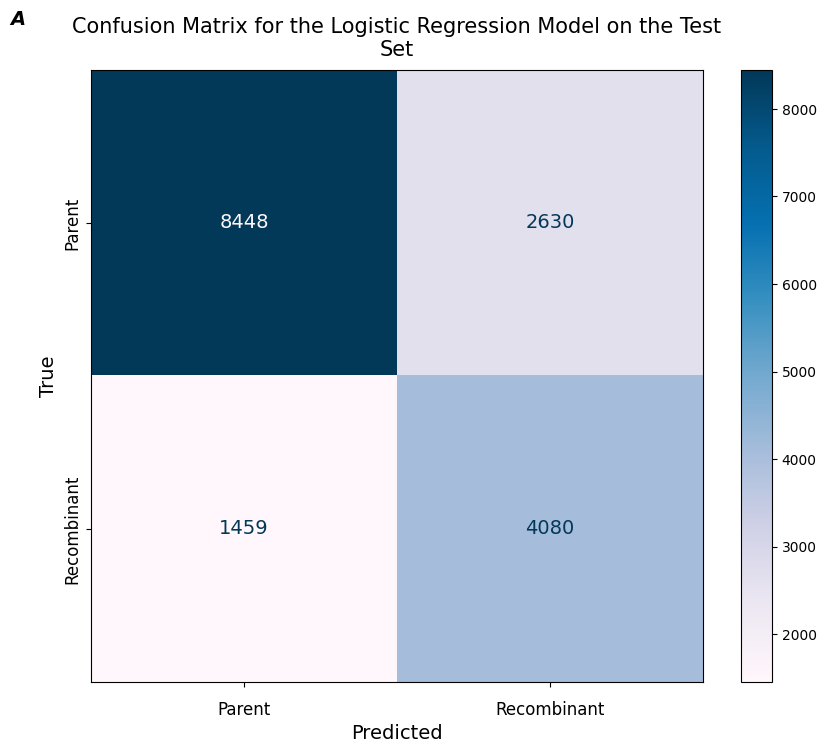

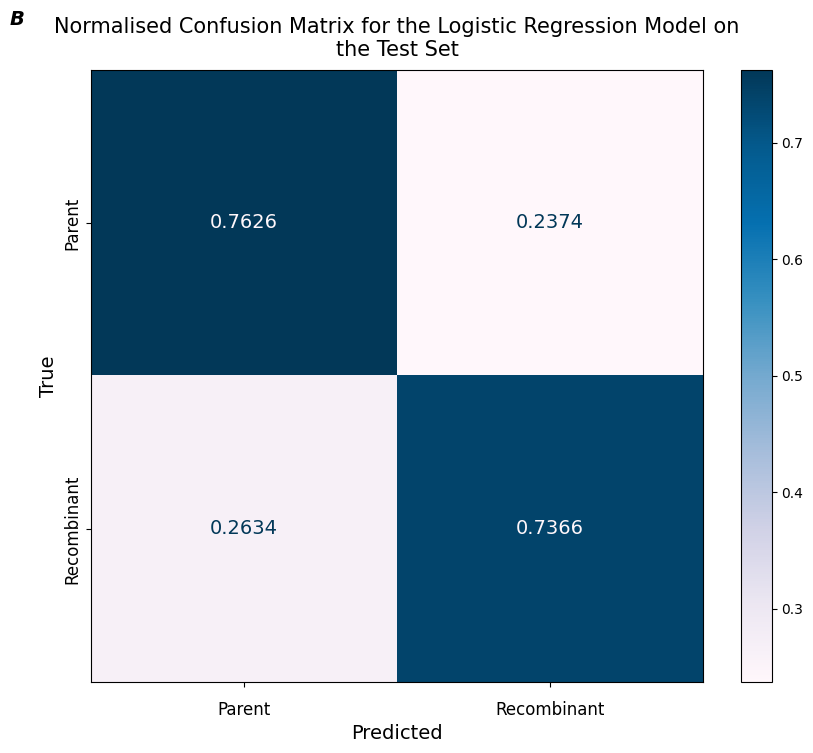

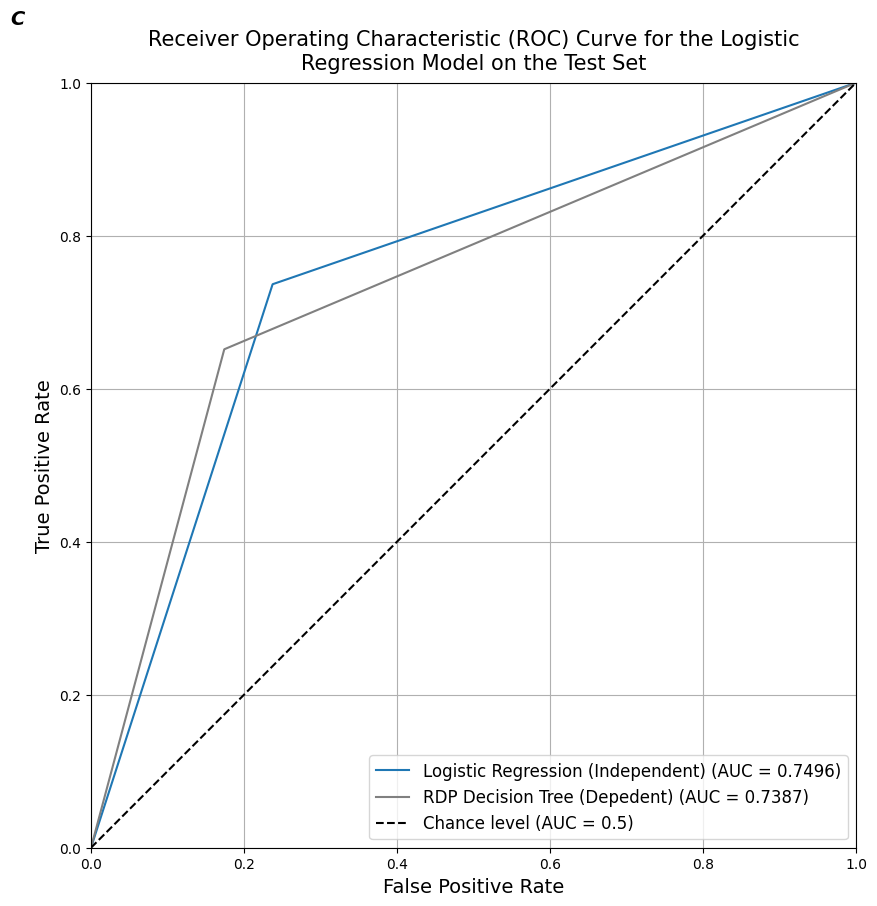

In [72]:
print("Evaluation on 'Unseen' test set")
y_probs =  logreg.predict_proba(X_unseen)[:, 1]
y_preds = logreg.predict(X_unseen)

#Classification Report
class_report(y_true=y_unseen, y_preds=y_preds)

# Use standard confusion matrix function 
disp, ax = StdConfMatrix(y_unseen, y_preds, figure_number='A')
title = "Confusion Matrix for the Logistic Regression Model on the Test Set"
wrapped_title = textwrap.fill(title, width=64)
ax.set_title(wrapped_title, pad=10, size=15) 
plt.show()

# Use standard confusion matrix function 
disp, ax = StdConfMatrix(y_unseen, y_preds, normalise='true', format='.4f', figure_number='B')
title = "Normalised Confusion Matrix for the Logistic Regression Model on the Test Set"
wrapped_title = textwrap.fill(title, width=64)
ax.set_title(wrapped_title, pad=10, size=15) 
plt.show()


# ROC Curve
title = "Receiver Operating Characteristic (ROC) Curve for the Logistic Regression Model on the Test Set"
wrapped_title = textwrap.fill(title, width=68)
fig, ax = StdRocCurve(
    y_true=y_unseen,
    y_probs_list=[y_preds,RDPPreds],
    model_names=["Logistic Regression (Independent)", "RDP Decision Tree (Depedent)"],
    figure_number='C',
    colors=['#1f77b4', '#808080'],
)
ax.set_title(wrapped_title, pad=10, size=15)
plt.show()

>Dependant Predictions

In [104]:
#Make dependant predictions - only take the index of the most confident choice from the triplet. 
probs = logreg.predict_proba(X_unseen)
dep_preds = pd.Series()

for i in range(0, len(probs), 3):
    triplet = pd.Series(data = [probs[i][1], probs[i+1][1], probs[i+2][1]])
    indx = triplet.idxmax()
    new = pd.Series([0, 0, 0], index=[i, i+1, i+2])
    new.loc[i+indx] = 1
    dep_preds = pd.concat([dep_preds, new], ignore_index=False)

/tmp/ipykernel_508110/3410978906.py:12: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  dep_preds = pd.concat([dep_preds, new], ignore_index=False)


In [105]:
dep_preds.to_csv('models_test/LogRegdep_preds.csv', sep=",", index=False)

Dependent predictions on the 'Unseen' test set
              precision    recall  f1-score   support

      Parent     0.8354    0.8354    0.8354     11078
 Recombinant     0.6709    0.6709    0.6709      5539

    accuracy                         0.7806     16617
   macro avg     0.7532    0.7532    0.7532     16617
weighted avg     0.7806    0.7806    0.7806     16617



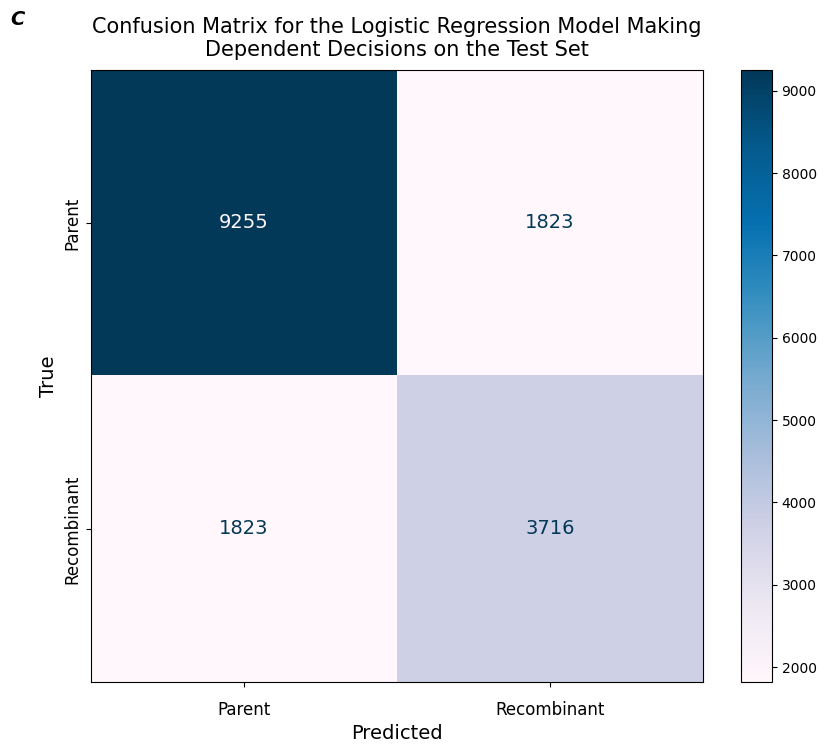

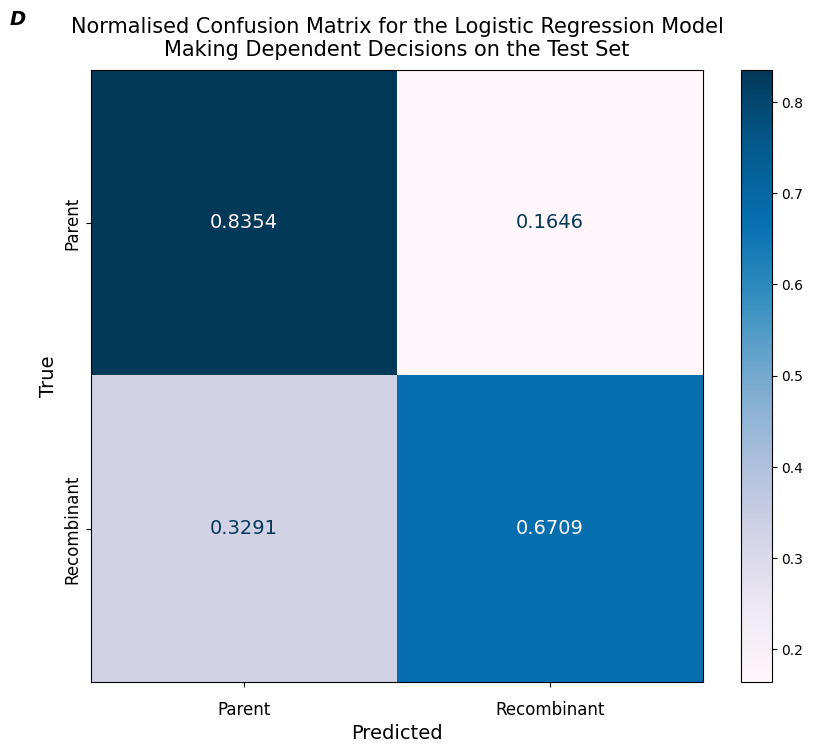

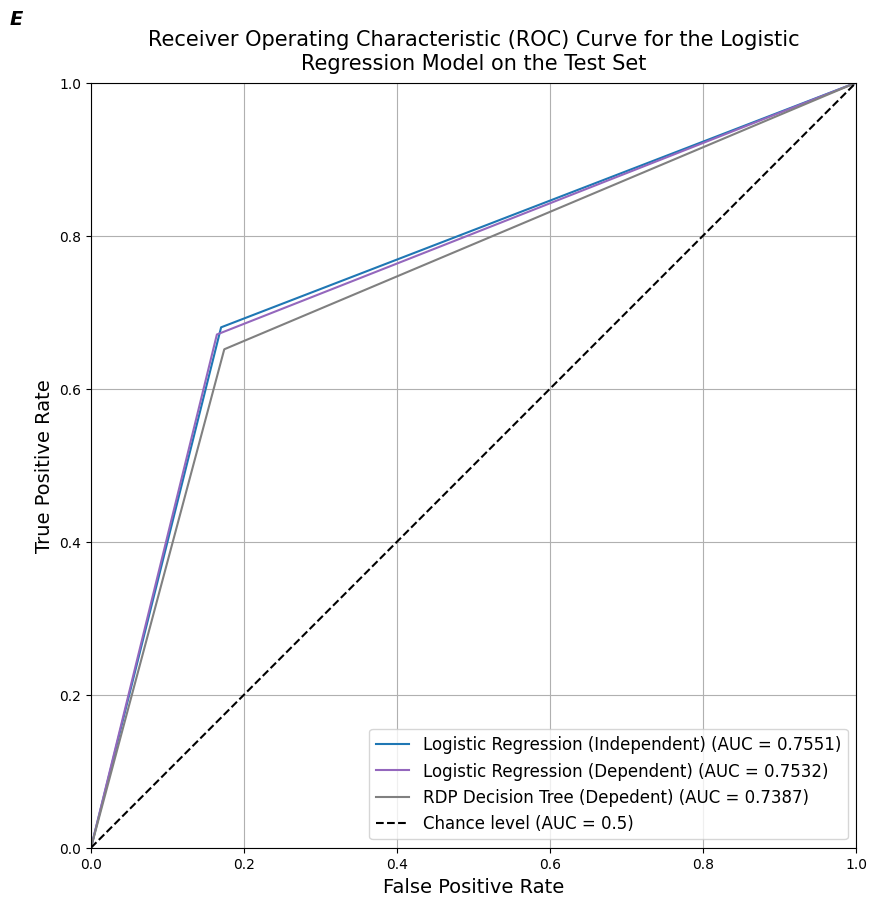

In [106]:
print("Dependent predictions on the 'Unseen' test set")

#Classification Report
class_report(y_true=y_unseen, y_preds=dep_preds)

# Use standard confusion matrix function 
disp, ax = StdConfMatrix(y_unseen, dep_preds, figure_number='C')
title = "Confusion Matrix for the Logistic Regression Model Making Dependent Decisions on the Test Set"
wrapped_title = textwrap.fill(title, width=64)
ax.set_title(wrapped_title, pad=10, size=15) 
plt.show()

disp, ax = StdConfMatrix(y_unseen, dep_preds, normalise='true', format='.4f', figure_number='D')
title = "Normalised Confusion Matrix for the Logistic Regression Model Making Dependent Decisions on the Test Set"
wrapped_title = textwrap.fill(title, width=64)
ax.set_title(wrapped_title, pad=10, size=15) 
plt.show()

# ROC Curve
title = "Receiver Operating Characteristic (ROC) Curve for the Logistic Regression Model on the Test Set"
wrapped_title = textwrap.fill(title, width=68)
fig, ax = StdRocCurve(
    y_true=y_unseen,
    y_probs_list=[y_preds, dep_preds, RDPPreds],
    model_names=["Logistic Regression (Independent)","Logistic Regression (Dependent)", "RDP Decision Tree (Depedent)"],
    figure_number='E',
    colors=['#1f77b4','#9467bd', '#808080'],
)
ax.set_title(wrapped_title, pad=10, size=15)
plt.show()

#### Determine Feature Importance

In [64]:
StatLabels = ['O:E Metric', 
              'SimScore Metric B', 
              'SimScore Metric A', 
              'PHYLPRO (PhPr)', 
              'TreePhPr (Branch)',
              'PhPrScore3', 
              'SubDist Metric', 
              'SetDistT Metric', 
              'SetDistP Metric', 
              'SubPhPr Metric',
              'TreeSubDist', 
              'SubPhPrScore2A', 
              'ParsimonyO 1', 
              'ParsimonyO 2', 
              'ParsimonyO 3',
              'ParsimonyO 4', 
              'ParsimonyI 1', 
              'ParsimonyI 2', 
              'ParsimonyI 3', 
              'ParsimonyI 4',
              'ParsimonyO 5', 
              'ParsimonyO 6', 
              'TRP Score', 
              'Conflict', 
              'OUListA',
              'O:E Dist Metric', 
              'O:E Dist Metric 3', 
              'OuCheck Metric', 
              'SetTot Metric', 
              'RankF0 metric',
              'RankF1 metric', 
              'dMax (VisRD)'
        ]

In [68]:
# Create the dataframe
column_to_statlabel_df = pd.DataFrame({
    'Column': X_test.columns,
    'StatLabel': StatLabels
})

# Print the dataframe
print(column_to_statlabel_df)

            Column          StatLabel
0        ListCorrA         O:E Metric
1       SimScoreBA  SimScore Metric B
2        SimScoreA  SimScore Metric A
3       PhPrScoreA     PHYLPRO (PhPr)
4      PhPrScore2A  TreePhPr (Branch)
5      PhPrScore3A         PhPrScore3
6        SubScoreA     SubDist Metric
7          SSDistA    SetDistT Metric
8        OUIndexAA    SetDistP Metric
9    SubPhPrScoreA     SubPhPr Metric
10      SubScore2A        TreeSubDist
11  SubPhPrScore2A     SubPhPrScore2A
12        RCompatA       ParsimonyO 1
13       RCompat2A       ParsimonyO 2
14       RCompat3A       ParsimonyO 3
15       RCompat4A       ParsimonyO 4
16       RCompatSA       ParsimonyI 1
17      RCompatS2A       ParsimonyI 2
18      RCompatS3A       ParsimonyI 3
19      RCompatS4A       ParsimonyI 4
20       RCompatCA       ParsimonyO 5
21       RCompatDA       ParsimonyO 6
22       TrpScoreA          TRP Score
23       BadDistsA           Conflict
24         OUListA            OUListA
25      List

In [50]:
# Get feature importance from coefficients
feature_importance = np.abs(logreg.coef_[0])  # Take absolute values
# Create feature importance dictionary
importance_dict = dict(zip(StatLabels, feature_importance))
sorted_importance = dict(sorted(importance_dict.items(), key=lambda x: x[1], reverse=True))

# Convert dictionary to DataFrame
sorted_importance_df = pd.DataFrame(sorted_importance.items(), columns=['Feature', 'Importance'])

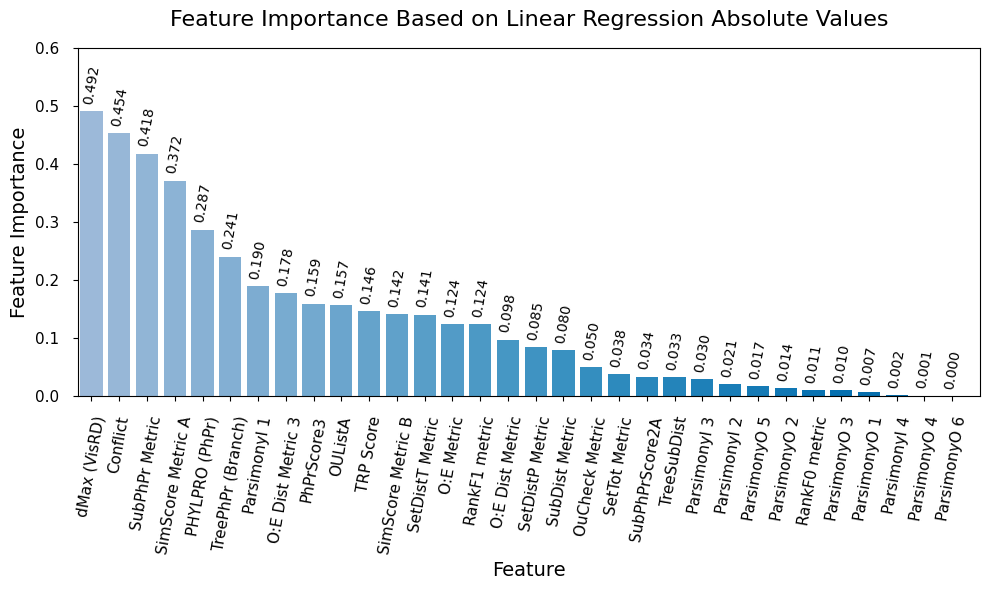

In [51]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.PuBu(np.linspace(0.4, 0.8, len(sorted_importance_df)))

# Create bars
bars = ax.bar(sorted_importance_df['Feature'], 
              sorted_importance_df['Importance'], 
              color=colors)

# Add value labels above each bar
for bar in bars:
    height = bar.get_height()
    ax.text(
        x=bar.get_x() + bar.get_width()/2,
        y=height + 0.01,  # Small offset above bar
        s=f'{height:.3f}',  # Format to 3 decimal places
        ha='center',
        va='bottom',
        fontsize=10,
        rotation =80
    )

# Adjust tick sizes, rotation, and padding
ax.tick_params(axis='x', labelsize=11, pad=10)
ax.tick_params(axis='y', labelsize=11, pad=10)

# Set x-axis labels
ax.set_xticks(sorted_importance_df['Feature'])
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=80,
    va='top',
    ha='center'
)

# Set axis limits
ax.set_xlim([-0.5, len(sorted_importance_df)])
ax.set_ylim([0.0, 0.60])

# Set labels and title
ax.set_xlabel('Feature', fontsize=14)
ax.set_ylabel('Feature Importance', fontsize=14)

title = "Feature Importance Based on Linear Regression Absolute Values"
wrapped_title = textwrap.fill(title, width=64)
ax.set_title(wrapped_title, pad=16, size=16) 

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.grid(visible=False)
plt.show()

In [52]:
# Get feature importance from coefficients
feature_importance = logreg.coef_[0]  # Take absolute values 
# Create feature importance dictionary
importance_dict = dict(zip(StatLabels, feature_importance))
sorted_importance = dict(sorted(importance_dict.items(), key=lambda x: x[1], reverse=True))

# Convert dictionary to DataFrame
sorted_importance_df = pd.DataFrame(sorted_importance.items(), columns=['Feature', 'Importance'])

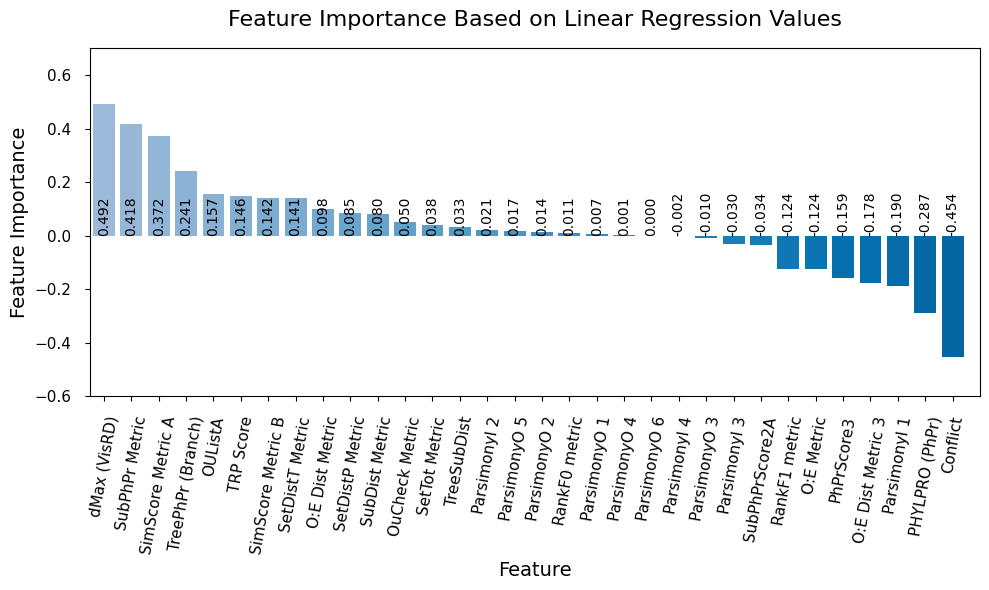

In [53]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.PuBu(np.linspace(0.4, 0.8, len(sorted_importance_df)))

# Create bars
bars = ax.bar(sorted_importance_df['Feature'], 
              sorted_importance_df['Importance'], 
              color=colors)

# Add value labels above each bar
for bar in bars:
    height = bar.get_height()
    ax.text(
        x=bar.get_x() + bar.get_width()/2,
        y=0,#height + 0.01,  # Small offset above bar
        s=f'{height:.3f}',  # Format to 3 decimal places
        ha='center',
        va='bottom',
        fontsize=10,
        rotation =90
    )

# Adjust tick sizes, rotation, and padding
ax.tick_params(axis='x', labelsize=11, pad=10)
ax.tick_params(axis='y', labelsize=11, pad=10)

# Set x-axis labels
ax.set_xticks(sorted_importance_df['Feature'])
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=80,
    va='top',
    ha='center'
)

# Set axis limits
ax.set_xlim([-0.5, len(sorted_importance_df)])
ax.set_ylim([-0.6, 0.70])

# Set labels and title
ax.set_xlabel('Feature', fontsize=14)
ax.set_ylabel('Feature Importance', fontsize=14)

title = "Feature Importance Based on Linear Regression Values"
wrapped_title = textwrap.fill(title, width=64)
ax.set_title(wrapped_title, pad=16, size=16) 

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.grid(visible=False)
plt.show()

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def analyze_recombinant_correlations(X_data, y_true, y_pred, feature_names, selected_features=None):
    """
    Analyze feature correlations for misclassified recombinants
    
    Parameters:
    -----------
    X_data : np.ndarray or pd.DataFrame
        Feature matrix
    y_true : np.ndarray or pd.Series
        True labels (1 for recombinant, 0 for parent)
    y_pred : np.ndarray
        Predicted labels (1 for recombinant, 0 for parent)
    feature_names : list or Index
        Names of all features
    selected_features : list, optional
        List of feature names to focus on. If None, uses all features
    """
    # Convert to numpy if needed
    if isinstance(X_data, pd.DataFrame):
        feature_names = feature_names
        X_data = X_data.values
    
    if isinstance(y_true, pd.Series):
        y_true = y_true.values
    
    # Ensure y_pred is 1D
    y_pred = y_pred.ravel()
    
    # Verify dimensions
    if len(feature_names) != X_data.shape[1]:
        raise ValueError(f"Feature names length ({len(feature_names)}) does not match data columns ({X_data.shape[1]})")
    
    # Create mask for misclassified recombinants
    misclassified_mask = (y_true == 1) & (y_pred == 0)
    
    # Get data for misclassified recombinants
    misc_data = X_data[misclassified_mask]
    
    if len(misc_data) == 0:
        raise ValueError("No misclassified recombinants found in the dataset")
    
    # If specific features are selected, filter the data
    if selected_features is not None:
        feature_indices = [list(feature_names).index(f) for f in selected_features]
        misc_data = misc_data[:, feature_indices]
        plot_features = selected_features
    else:
        plot_features = feature_names
    
    # Calculate correlation matrix
    corr_matrix = np.corrcoef(misc_data.T)
    
    # Plot correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr_matrix,
        annot=True,
        cmap='coolwarm',
        xticklabels=plot_features,
        yticklabels=plot_features,
        fmt='.2f'
    )
    plt.title("Correlation Matrix for Recombinants Misclassified as Parents")
    plt.tight_layout()
    plt.show()
    
    return corr_matrix, plot_features

def analyze_recombinant_misclassifications(X_data, y_true, y_pred, feature_names):
    """
    Memory-efficient analysis of recombinants misclassified as parents
    
    Parameters:
    -----------
    X_data : np.ndarray or pd.DataFrame
        Feature matrix
    y_true : np.ndarray or pd.Series
        True labels (1 for recombinant, 0 for parent)
    y_pred : np.ndarray
        Predicted labels (1 for recombinant, 0 for parent)
    feature_names : list or Index
        Names of the features
    """
    # Convert to numpy if needed
    if isinstance(X_data, pd.DataFrame):
        feature_names = feature_names
        X_data = X_data.values
    
    if isinstance(y_true, pd.Series):
        y_true = y_true.values
    
    # Ensure y_pred is 1D
    y_pred = y_pred.ravel()
    
    # Get dimensions
    n_samples = len(y_true)
    n_features = len(feature_names)
    
    # Verify dimensions
    if X_data.shape[1] != n_features:
        raise ValueError(f"Feature names length ({n_features}) does not match data columns ({X_data.shape[1]})")
    
    # Create masks
    misclassified_mask = (y_true == 1) & (y_pred == 0)
    correctly_classified_mask = (y_true == 1) & (y_pred == 1)
    
    n_misclassified = np.sum(misclassified_mask)
    n_correct = np.sum(correctly_classified_mask)
    
    print(f"Total recombinants: {np.sum(y_true == 1)}")
    print(f"Recombinants misclassified as parents: {n_misclassified}")
    print(f"Correctly classified recombinants: {n_correct}")
    print(f"False negative rate: {n_misclassified/np.sum(y_true == 1)*100:.2f}%")
    
    # Calculate statistics
    misc_mean = np.mean(X_data[misclassified_mask], axis=0)
    correct_mean = np.mean(X_data[correctly_classified_mask], axis=0)
    misc_var = np.var(X_data[misclassified_mask], axis=0)
    correct_var = np.var(X_data[correctly_classified_mask], axis=0)
    
    # Calculate effect sizes
    pooled_std = np.sqrt((misc_var + correct_var) / 2)
    effect_sizes = (misc_mean - correct_mean) / pooled_std
    
    # Create results DataFrame
    feature_stats = pd.DataFrame({
        'feature': feature_names,
        'mean_diff': misc_mean - correct_mean,
        'effect_size': effect_sizes,
        'mean_misclassified': misc_mean,
        'mean_correct': correct_mean
    })
    
    # Sort by absolute effect size
    feature_stats['abs_effect_size'] = np.abs(feature_stats['effect_size'])
    feature_stats = feature_stats.sort_values('abs_effect_size', ascending=False)
    
    # Plot top 10 features
    plt.figure(figsize=(12, 6))
    top_10_features = feature_stats.head(10)
    plt.bar(range(10), top_10_features['effect_size'])
    plt.xticks(range(10), top_10_features['feature'], rotation=45, ha='right')
    plt.title("Top 10 Features: Effect Size Between Correct and Misclassified Recombinants")
    plt.ylabel("Effect Size (Cohen's d)")
    plt.tight_layout()
    plt.show()
    
    return feature_stats

In [59]:
y_pred = pd.read_csv('models_test/LogRegdep_preds.csv')

Total recombinants: 5539
Recombinants misclassified as parents: 1823
Correctly classified recombinants: 3716
False negative rate: 32.91%


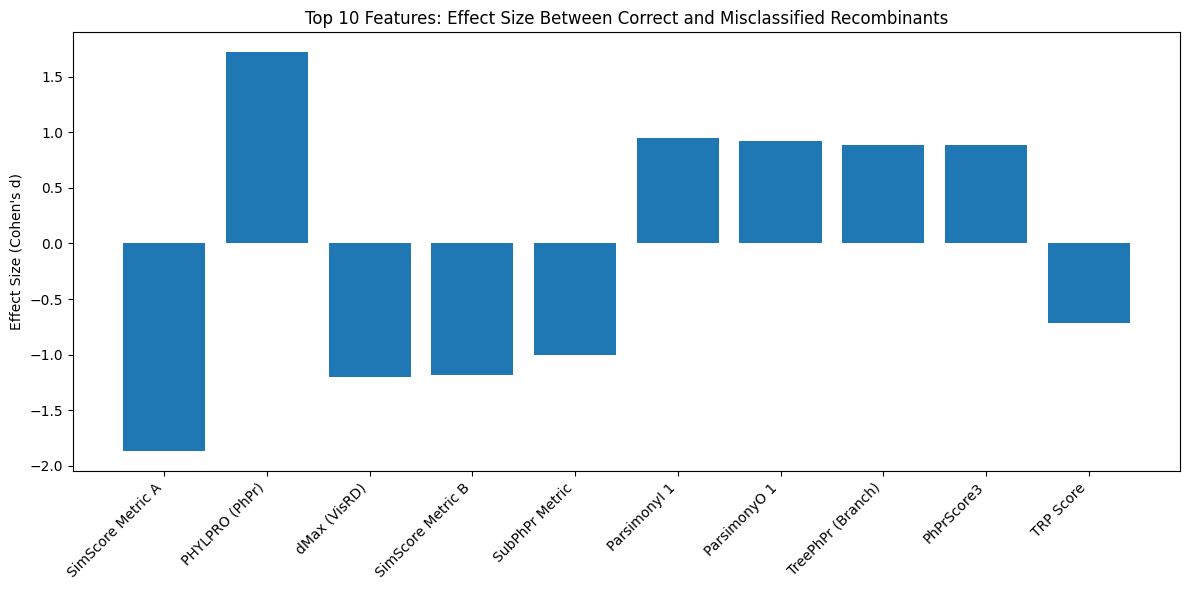

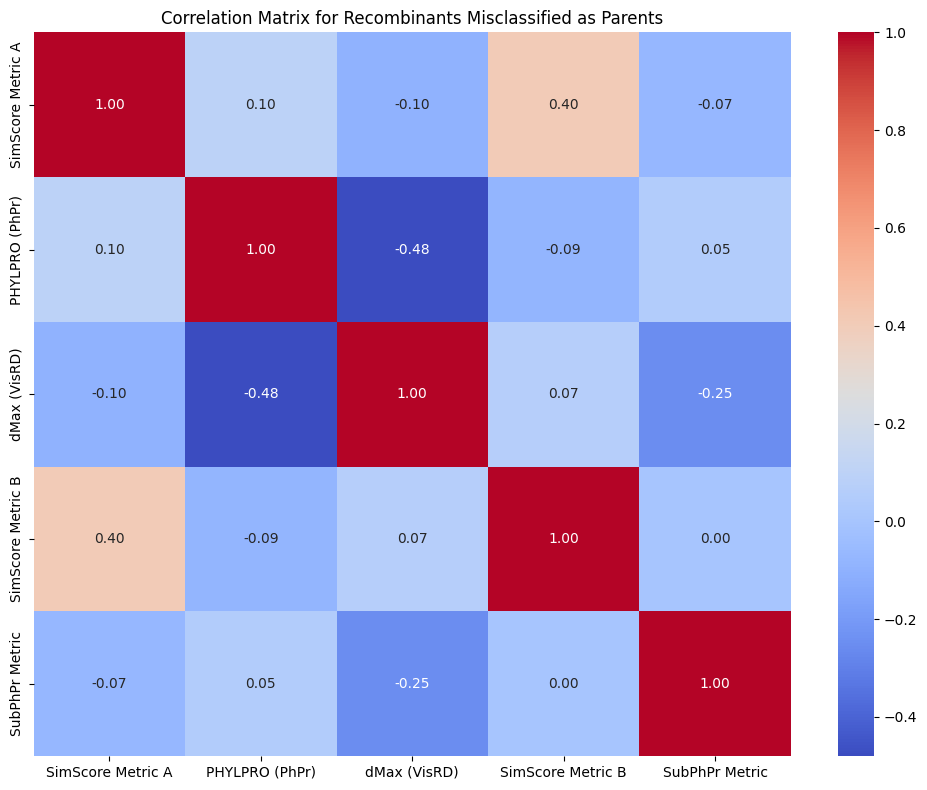

In [60]:
stats = analyze_recombinant_misclassifications(X_unseen, y_unseen.to_numpy(), y_pred.to_numpy().reshape(-1,), StatLabels)
top_features = stats.head(5)['feature'].tolist()
corr_matrix, features = analyze_recombinant_correlations(X_unseen, y_unseen.to_numpy(), y_pred.to_numpy().reshape(-1,), StatLabels, top_features)

### Gradient Booster Classifier LightGBM Style

In [83]:
from sklearn.ensemble import HistGradientBoostingClassifier

est = HistGradientBoostingClassifier(
        random_state=42,
        max_iter= 5000,
        learning_rate= 0.01,
        l2_regularization= 0.3,
        max_features=0.95,
        warm_start= False,
        validation_fraction= 0.025,
        verbose= 10,
        class_weight= 'balanced',
        early_stopping=True,
    ).fit(X_train, y_train,)

Binning 0.116 GB of training data: 0.340 s
Binning 0.003 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
[1/5000] 1 tree, 31 leaves, max depth = 6, train loss: 0.68946, val loss: 0.68943, in 0.040s
[2/5000] 1 tree, 31 leaves, max depth = 6, train loss: 0.68585, val loss: 0.68580, in 0.039s
[3/5000] 1 tree, 31 leaves, max depth = 7, train loss: 0.68230, val loss: 0.68222, in 0.044s
[4/5000] 1 tree, 31 leaves, max depth = 7, train loss: 0.67883, val loss: 0.67872, in 0.037s
[5/5000] 1 tree, 31 leaves, max depth = 7, train loss: 0.67541, val loss: 0.67529, in 0.036s
[6/5000] 1 tree, 31 leaves, max depth = 6, train loss: 0.67207, val loss: 0.67193, in 0.040s
[7/5000] 1 tree, 31 leaves, max depth = 7, train loss: 0.66878, val loss: 0.66862, in 0.039s
[8/5000] 1 tree, 31 leaves, max depth = 7, train loss: 0.66556, val loss: 0.66538, in 0.040s
[9/5000] 1 tree, 31 leaves, max depth = 7, train loss: 0.66239, val loss: 0.66220, in 0.037s
[10/5000] 1 tree, 31 leaves, max depth = 6

>Save the model

In [198]:
from joblib import dump

# Save the model.
dump(est, 'models_test/gradboost.joblib')

['models_test/gradboost.joblib']

In [88]:
from joblib import load

# Load the model if needed.
est = load('models_test/gradboost.joblib')

In [90]:
est.score(X_unseen, y_unseen)

0.7667448998014081

### Test Set

Evaluation on 'Unseen' test set
              precision    recall  f1-score   support

      Parent     0.8582    0.7788    0.8166     11078
 Recombinant     0.6267    0.7427    0.6798      5539

    accuracy                         0.7667     16617
   macro avg     0.7424    0.7607    0.7482     16617
weighted avg     0.7810    0.7667    0.7710     16617



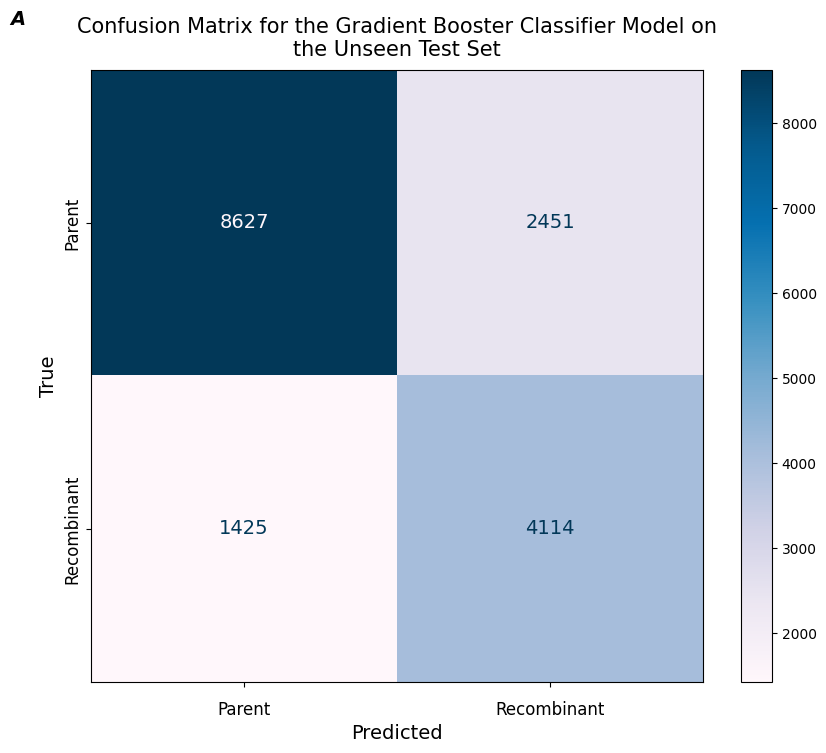

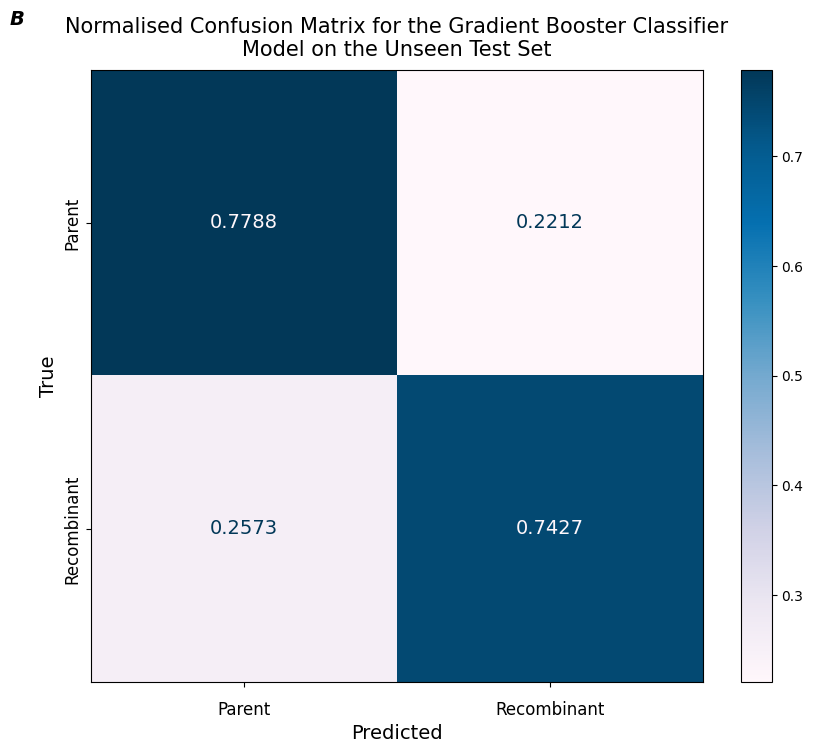

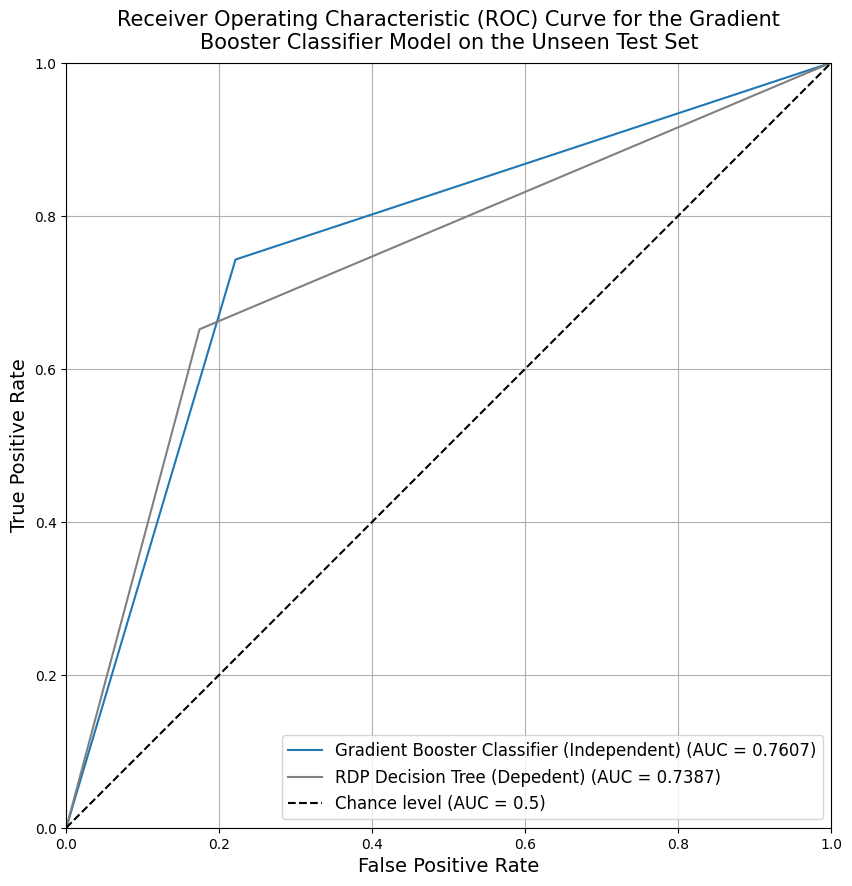

In [91]:
print("Evaluation on 'Unseen' test set")
y_probs =  est.predict_proba(X_unseen)[:, 1]
y_preds = est.predict(X_unseen)

#Classification Report
class_report(y_true=y_unseen, y_preds=y_preds)

# Use standard confusion matrix function 
disp, ax = StdConfMatrix(y_unseen, y_preds, figure_number='A')
title = "Confusion Matrix for the Gradient Booster Classifier Model on the Unseen Test Set"
wrapped_title = textwrap.fill(title, width=64)
ax.set_title(wrapped_title, pad=10, size=15) 
plt.show()

disp, ax = StdConfMatrix(y_unseen, y_preds, normalise='true', format='.4f', figure_number='B')
title = "Normalised Confusion Matrix for the Gradient Booster Classifier Model on the Unseen Test Set"
wrapped_title = textwrap.fill(title, width=64)
ax.set_title(wrapped_title, pad=10, size=15) 
plt.show()

# ROC Curve
title = "Receiver Operating Characteristic (ROC) Curve for the Gradient Booster Classifier Model on the Unseen Test Set"
wrapped_title = textwrap.fill(title, width=68)
fig, ax = StdRocCurve(
    y_true=y_unseen,
    y_probs_list=[y_preds, RDPPreds],
    model_names=["Gradient Booster Classifier (Independent)", "RDP Decision Tree (Depedent)"],
    colors=['#1f77b4', '#808080'],
)
ax.set_title(wrapped_title, pad=10, size=15)
plt.show()

> Dependent Decisions

In [107]:
#Make dependant predictions - only take the index of the most confident choice from the triplet. 
probs = est.predict_proba(X_unseen)
dep_preds = pd.Series()

for i in range(0, len(probs), 3):
    triplet = pd.Series(data = [probs[i][1], probs[i+1][1], probs[i+2][1]])
    indx = triplet.idxmax()
    new = pd.Series([0, 0, 0], index=[i, i+1, i+2])
    new.loc[i+indx] = 1
    # dep_preds.loc[len(dep_preds)] = indx
    # print(indx)
    dep_preds = pd.concat([dep_preds, new], ignore_index=False)

/tmp/ipykernel_508110/4164353503.py:12: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  dep_preds = pd.concat([dep_preds, new], ignore_index=False)


In [108]:
dep_preds.to_csv('models_test/GradDep_preds.csv', sep=",", index=False)

Evaluation on 'Unseen' test set
              precision    recall  f1-score   support

      Parent     0.8432    0.8432    0.8432     11078
 Recombinant     0.6864    0.6864    0.6864      5539

    accuracy                         0.7909     16617
   macro avg     0.7648    0.7648    0.7648     16617
weighted avg     0.7909    0.7909    0.7909     16617



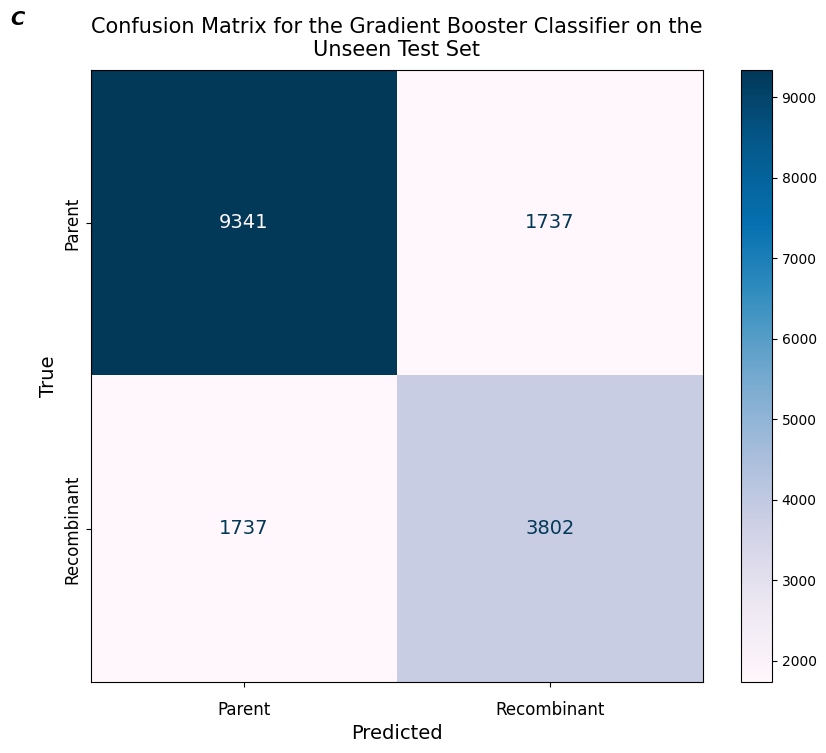

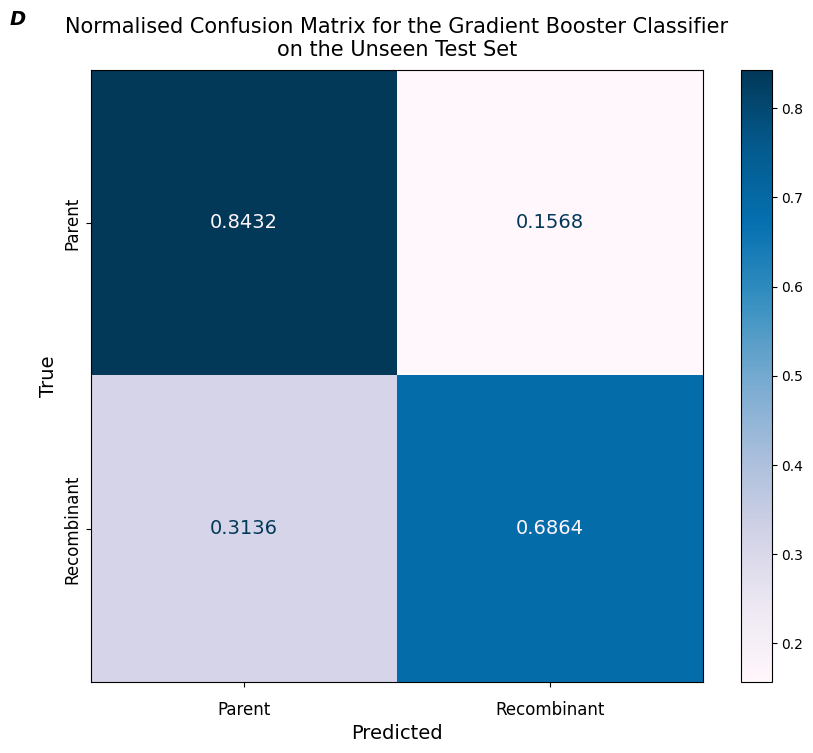

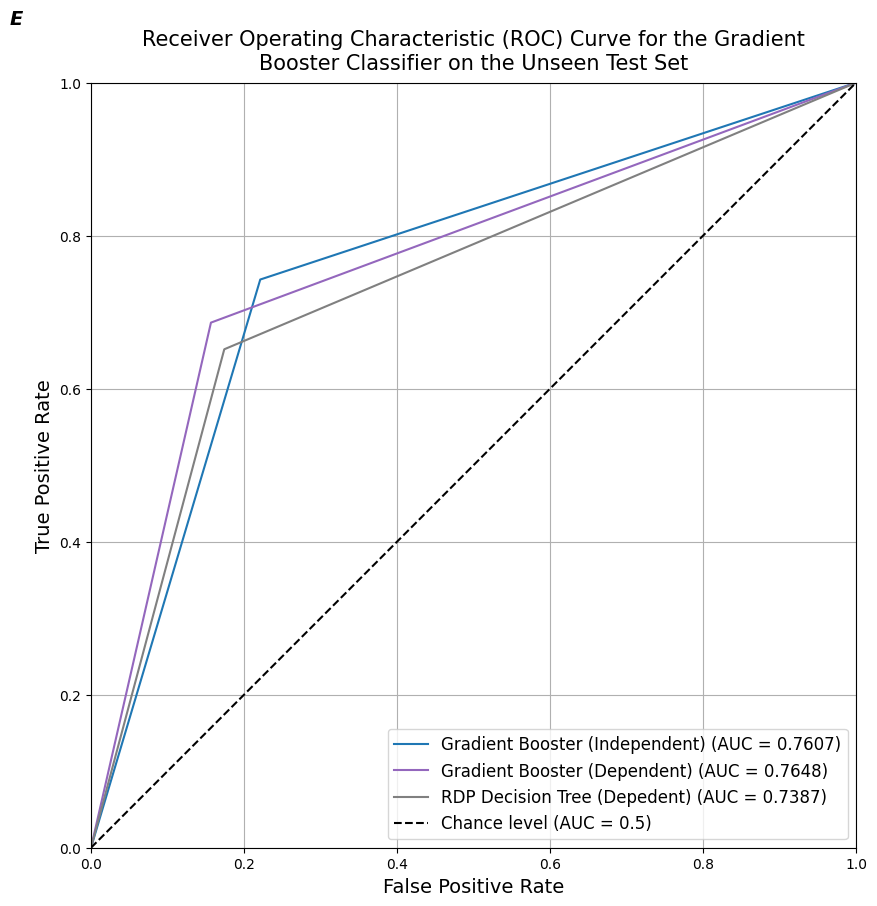

In [94]:
print("Evaluation on 'Unseen' test set")

#Classification Report
class_report(y_true=y_unseen, y_preds=dep_preds)

# Use standard confusion matrix function 
disp, ax = StdConfMatrix(y_unseen, dep_preds, figure_number='C')
title = "Confusion Matrix for the Gradient Booster Classifier on the Unseen Test Set"
wrapped_title = textwrap.fill(title, width=64)
ax.set_title(wrapped_title, pad=10, size=15) 
plt.show()

disp, ax = StdConfMatrix(y_unseen, dep_preds, normalise='true', format='.4f', figure_number='D')
title = "Normalised Confusion Matrix for the Gradient Booster Classifier on the Unseen Test Set"
wrapped_title = textwrap.fill(title, width=64)
ax.set_title(wrapped_title, pad=10, size=15) 
plt.show()

# ROC Curve
title = "Receiver Operating Characteristic (ROC) Curve for the Gradient Booster Classifier on the Unseen Test Set"
wrapped_title = textwrap.fill(title, width=68)
fig, ax = StdRocCurve(
    y_true=y_unseen,
    y_probs_list=[y_preds, dep_preds, RDPPreds],
    model_names=["Gradient Booster (Independent)","Gradient Booster (Dependent)", "RDP Decision Tree (Depedent)"],
    figure_number='E',
    colors=['#1f77b4','#9467bd', '#808080'],
)
ax.set_title(wrapped_title, pad=10, size=15)
plt.show()

### Random Forest

In [173]:
#Calculate class Weights from Sklearn for training
cw = class_weight.compute_class_weight(class_weight='balanced',
                                       classes=np.unique(y_train),
                                       y=y_train.values)
class_weights = {0: cw[0], 1: cw[1]}
#class_weights = {0: 0.3, 1: 0.7}
print('class weights:', class_weights)

class weights: {0: np.float64(0.75), 1: np.float64(1.5)}


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [174]:
rf = RandomForestClassifier(
    n_estimators=280,          # Number of trees
    max_depth=16,              # Maximum depth of each tree
    min_samples_split=5,       # Minimum samples required to split node
    min_samples_leaf=2,        # Minimum samples required at leaf node
    max_features='sqrt',       # Number of features to consider at each split
    max_leaf_nodes=None,       # Maximum number of leaf nodes
    min_impurity_decrease=0.0, # Minimum decrease in impurity required for split
    class_weight={0: 0.75, 1: 1.5}, # Keep existing class weights
    random_state=42,           # For reproducibility
    n_jobs=-1,                 # Use all available cores
)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.75, 1: 1.5}, max_depth=16,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=280, n_jobs=-1, random_state=42)

In [199]:
from joblib import dump

# Save the model.
dump(rf, 'models_test/RF.joblib')

['models_test/RF.joblib']

In [95]:
from joblib import load

# Load the model if needed.
rf = load('models_test/RF.joblib')

#### Test set


Evaluation on 'Unseen' test set
              precision    recall  f1-score   support

      Parent     0.8385    0.8299    0.8342     11078
 Recombinant     0.6667    0.6803    0.6734      5539

    accuracy                         0.7800     16617
   macro avg     0.7526    0.7551    0.7538     16617
weighted avg     0.7812    0.7800    0.7806     16617



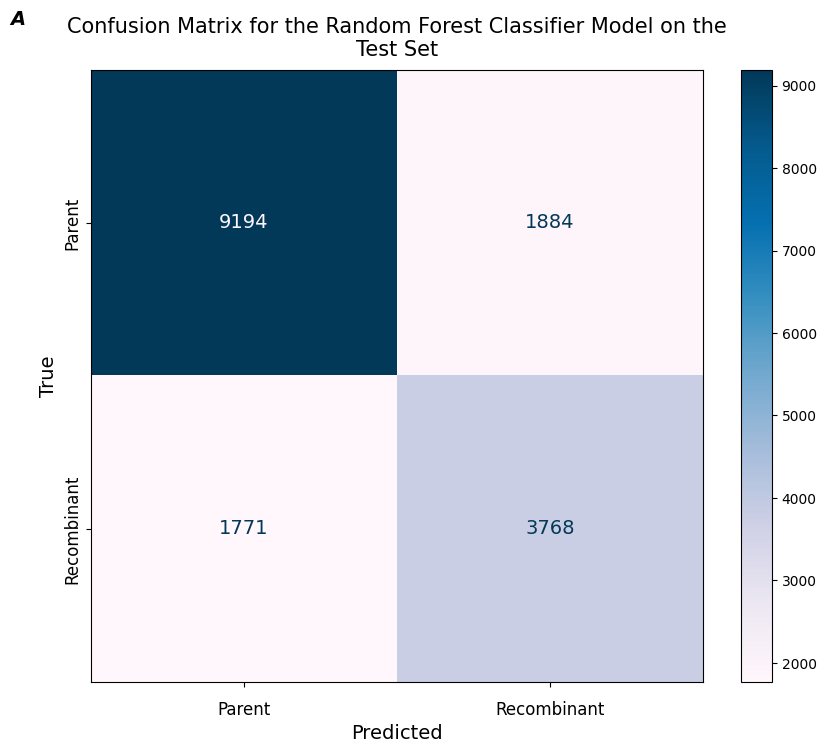

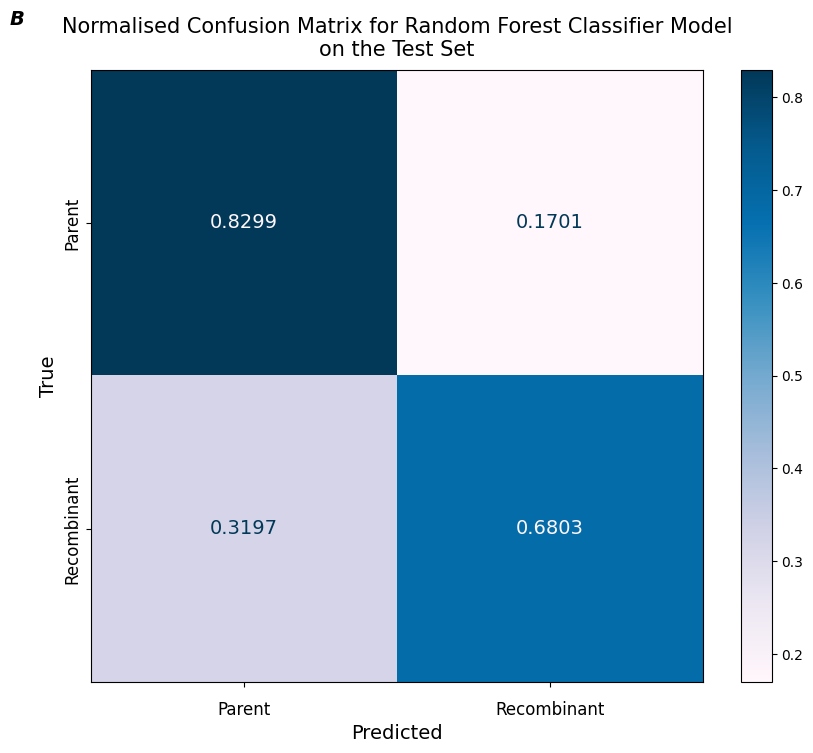

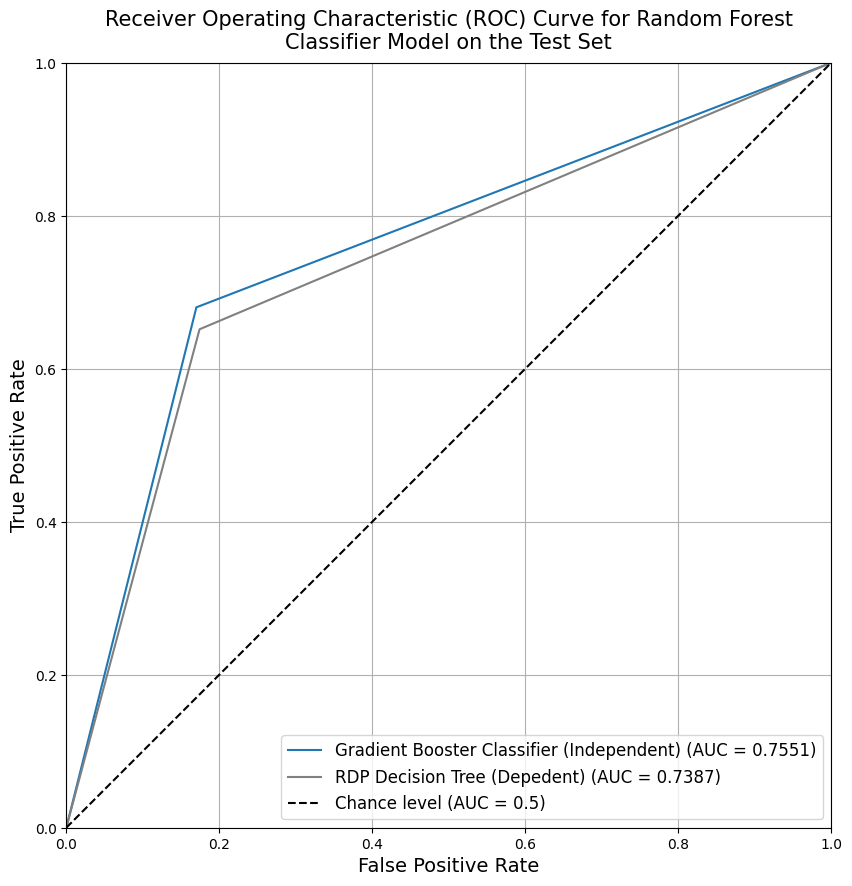

In [100]:
print("Evaluation on 'Unseen' test set")
y_probs =  rf.predict_proba(X_unseen)[:, 1]
y_preds = rf.predict(X_unseen)

#Classification Report
class_report(y_true=y_unseen, y_preds=y_preds)

# Use standard confusion matrix function 
disp, ax = StdConfMatrix(y_unseen, y_preds, figure_number='A')
title = "Confusion Matrix for the Random Forest Classifier Model on the Test Set"
wrapped_title = textwrap.fill(title, width=64)
ax.set_title(wrapped_title, pad=10, size=15)
plt.savefig("figures/RF_CM.png") 
plt.show()

disp, ax = StdConfMatrix(y_unseen, y_preds, normalise='true', format='.4f', figure_number='B')
title = "Normalised Confusion Matrix for Random Forest Classifier Model on the Test Set"
wrapped_title = textwrap.fill(title, width=64)
ax.set_title(wrapped_title, pad=10, size=15) 
plt.savefig("figures/RF_NCM.png") 
plt.show()

# ROC Curve
title = "Receiver Operating Characteristic (ROC) Curve for Random Forest Classifier Model on the Test Set"
wrapped_title = textwrap.fill(title, width=68)
fig, ax = StdRocCurve(
    y_true=y_unseen,
    y_probs_list=[y_preds, RDPPreds],
    model_names=["Gradient Booster Classifier (Independent)", "RDP Decision Tree (Depedent)"],
    colors=['#1f77b4', '#808080'],
)
ax.set_title(wrapped_title, pad=10, size=15)
plt.savefig("figures/RF_ROC.png") 
plt.show()

In [109]:
#Make dependant predictions - only take the index of the most confident choice from the triplet. 
probs = rf.predict_proba(X_unseen)
dep_preds = pd.Series()

for i in range(0, len(probs), 3):
    triplet = pd.Series(data = [probs[i][1], probs[i+1][1], probs[i+2][1]])
    indx = triplet.idxmax()
    new = pd.Series([0, 0, 0], index=[i, i+1, i+2])
    new.loc[i+indx] = 1
    # dep_preds.loc[len(dep_preds)] = indx
    # print(indx)
    dep_preds = pd.concat([dep_preds, new], ignore_index=False)

/tmp/ipykernel_508110/2189530215.py:12: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  dep_preds = pd.concat([dep_preds, new], ignore_index=False)


In [110]:
dep_preds.to_csv('models_test/RFdep_preds.csv', sep=",", index=False)

Dependent predictions on the 'Unseen' test set
              precision    recall  f1-score   support

      Parent     0.8398    0.8398    0.8398     11078
 Recombinant     0.6795    0.6795    0.6795      5539

    accuracy                         0.7864     16617
   macro avg     0.7597    0.7597    0.7597     16617
weighted avg     0.7864    0.7864    0.7864     16617



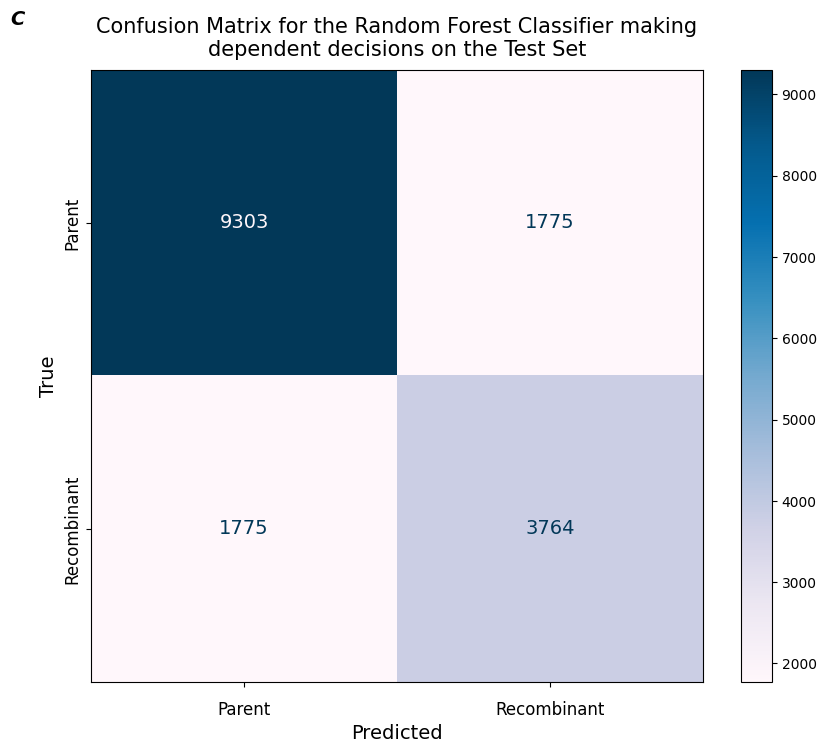

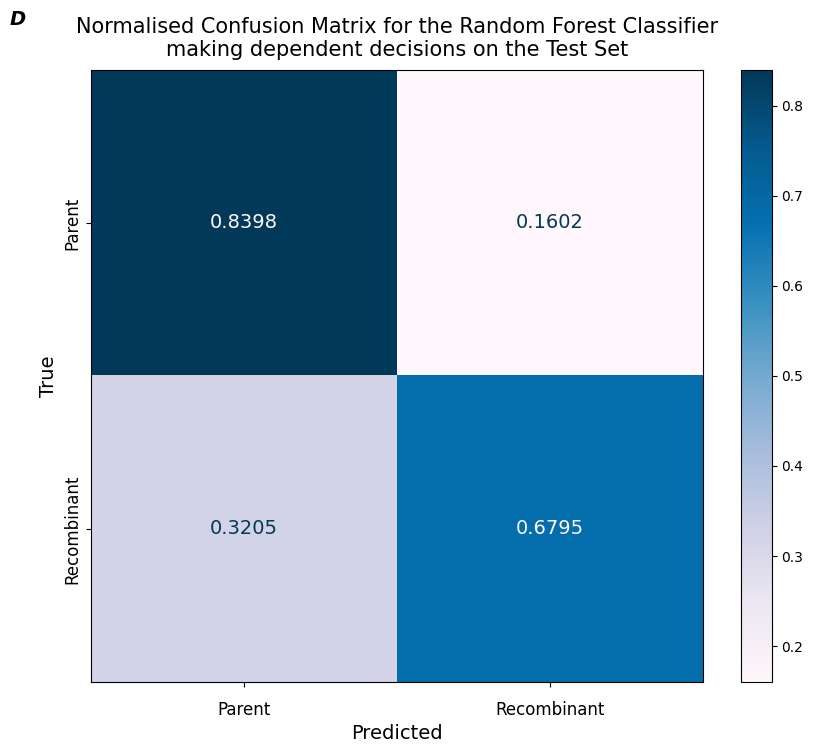

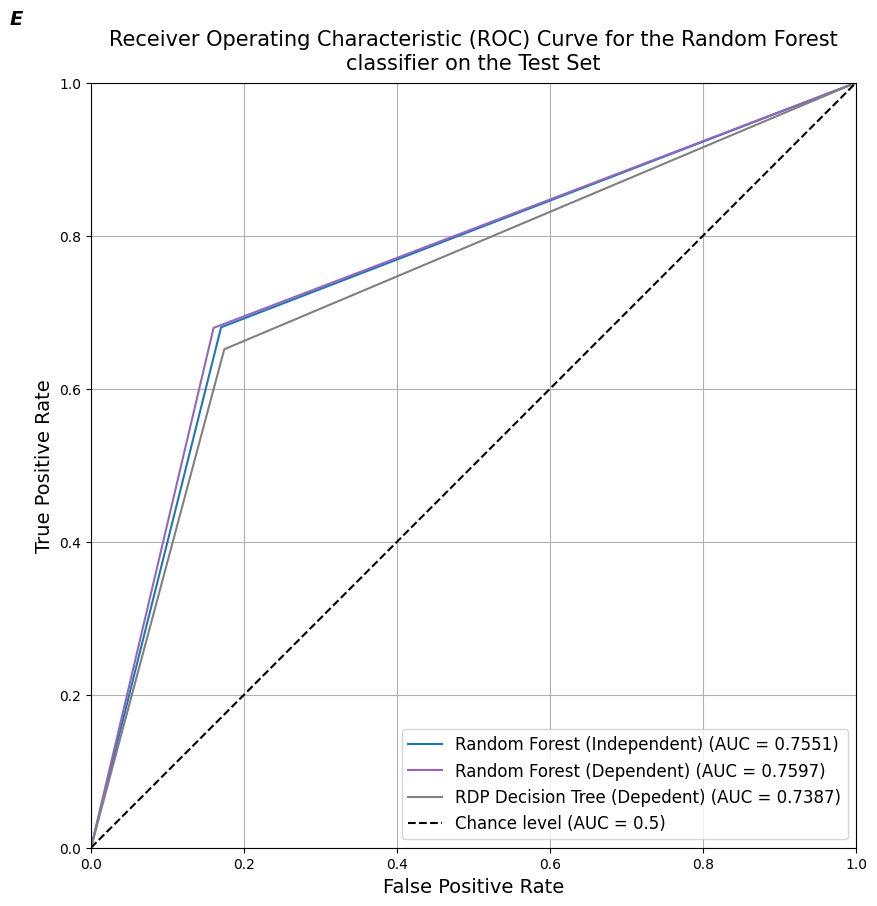

In [102]:
print("Dependent predictions on the 'Unseen' test set")
#Classification Report
class_report(y_true=y_unseen, y_preds=dep_preds)

# Use standard confusion matrix function 
disp, ax = StdConfMatrix(y_unseen, dep_preds, figure_number='C')
title = "Confusion Matrix for the Random Forest Classifier making dependent decisions on the Test Set"
wrapped_title = textwrap.fill(title, width=64)
ax.set_title(wrapped_title, pad=10, size=15) 
plt.savefig("figures/DRF_CM.png") 
plt.show()

disp, ax = StdConfMatrix(y_unseen, dep_preds, normalise='true', format='.4f', figure_number='D')
title = "Normalised Confusion Matrix for the Random Forest Classifier making dependent decisions on the Test Set"
wrapped_title = textwrap.fill(title, width=64)
ax.set_title(wrapped_title, pad=10, size=15) 
plt.savefig("figures/DRF_NCM.png") 
plt.show()

# ROC Curve
title = "Receiver Operating Characteristic (ROC) Curve for the Random Forest classifier on the Test Set"
wrapped_title = textwrap.fill(title, width=68)
fig, ax = StdRocCurve(
    y_true=y_unseen,
    y_probs_list=[y_preds, dep_preds, RDPPreds],
    model_names=["Random Forest (Independent)","Random Forest (Dependent)", "RDP Decision Tree (Depedent)"],
    figure_number='E',
    colors=['#1f77b4','#9467bd', '#808080'],
)
ax.set_title(wrapped_title, pad=10, size=15)
plt.savefig("figures/DRF_ROC.png") 
plt.show()

# Comparing all AUCs

In [243]:
BnnDepPreds = pd.read_csv("models_test/BNNdep_preds.csv")
GradDepPreds = pd.read_csv("models_test/GradDep_preds.csv")
LRDepPreds = pd.read_csv("models_test/LogRegdep_preds.csv")
RFDepPreds = pd.read_csv("models_test/RFdep_preds.csv")
RDPDepPreds = pd.read_csv("models_test/RDPdep_preds.csv")

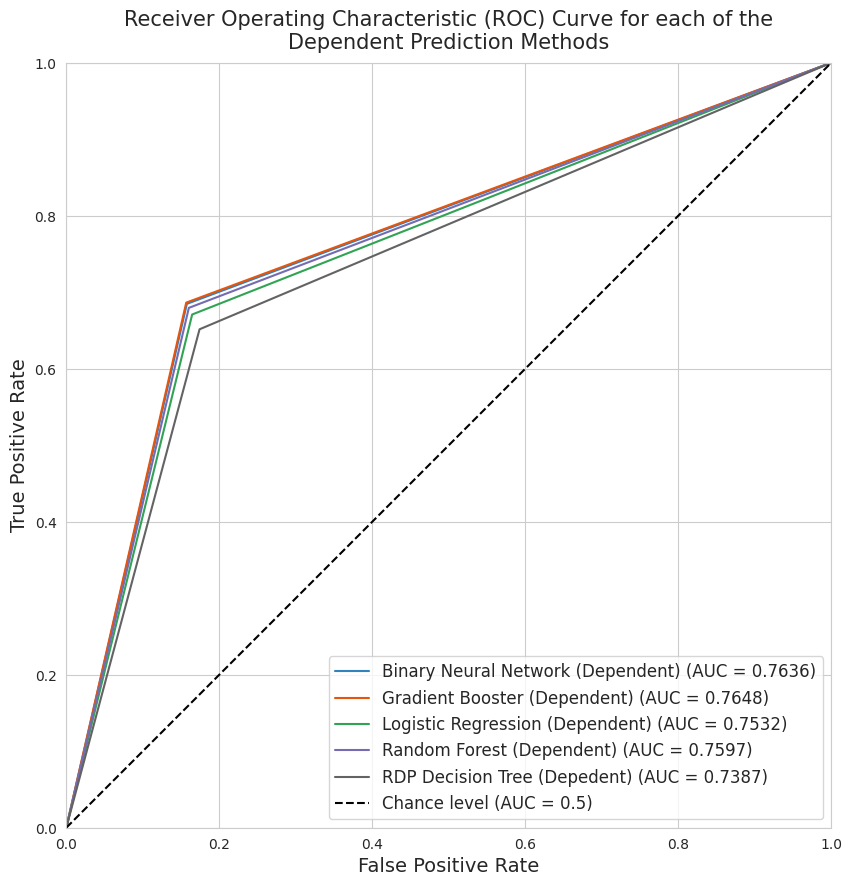

In [260]:
# ROC Curve
title = "Receiver Operating Characteristic (ROC) Curve for each of the Dependent Prediction Methods"
wrapped_title = textwrap.fill(title, width=68)

cmap = plt.get_cmap('tab20c')
models = [BnnDepPreds,GradDepPreds, LRDepPreds,RFDepPreds, RDPDepPreds]
fig, ax = StdRocCurve(
    y_true=y_unseen,
    y_probs_list=models,
    model_names=["Binary Neural Network (Dependent)", "Gradient Booster (Dependent)", "Logistic Regression (Dependent)","Random Forest (Dependent)", "RDP Decision Tree (Depedent)"],
    # figure_number='E',
    colors = [cmap(i/len(models)) for i in range(len(models))],
)
ax.set_title(wrapped_title, pad=10, size=15)
plt.savefig("figures/DRF_ROC.png") 
plt.show()

# Models Trialed but not used

### Gaussian Naive Bayes

In [25]:
from sklearn.naive_bayes import GaussianNB

gauss = GaussianNB()

gauss.fit(X_train, y_train)

GaussianNB()

In [26]:
gauss.score(X_test, y_test)

0.883183220748895

Evaluation on 'Unseen' test set
              precision    recall  f1-score   support

      Parent       0.90      0.91      0.90     11342
 Recombinant       0.81      0.80      0.81      5671

    accuracy                           0.87     17013
   macro avg       0.86      0.86      0.86     17013
weighted avg       0.87      0.87      0.87     17013



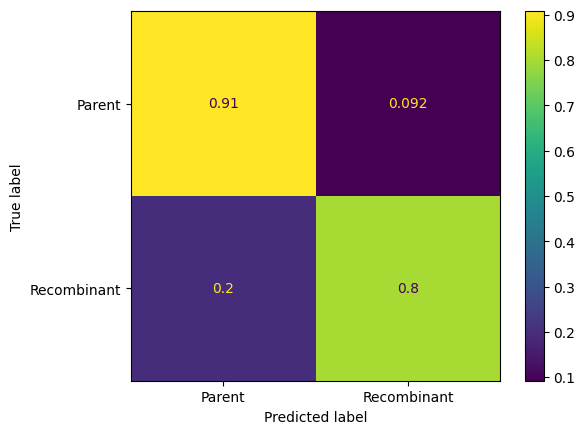

In [27]:
print("Evaluation on 'Unseen' test set")
preds =  gauss.predict(X_unseen)
# probs = probs[:, 1]
# y_preds = list(map(lambda x: 0 if x < 0.5 else 1, probs))
class_report(y_unseen, preds)

### Voting Ensemble of Multiple Algorithms

#### Hard Voting

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

hardVote = VotingClassifier(estimators=[('logisticReg', logreg),('GradBoost', est), ('rf', rf), ('gnb', gauss)], voting='hard')

In [ ]:
for clf, label in zip([logreg, est, rf, gauss, hardVote], ['Logistic Regression', 'GradBoost', 'Random Forest', 'naive Bayes', 'HardVoteEnsemble']):
    scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=3)
    print("Accuracy: %0.5f (+/- %0.5f) [%s]" % (scores.mean(), scores.std(), label))

#### Soft Voting

In [ ]:
softVote = VotingClassifier(estimators=[('logisticReg', logreg),('GradBoost', est), ('rf', rf), ('gnb', gauss)], voting='soft')

In [ ]:
softVote.fit(X_train, y_train)

In [ ]:
print("Evaluation on 'Unseen' test set")
preds =  softVote.predict(X_unseen)
# probs = probs[:, 1]
# y_preds = list(map(lambda x: 0 if x < 0.5 else 1, probs))
class_report(y_unseen, preds)

### Nearest Neighbours

In [28]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(
    n_jobs=-1,
    n_neighbors = 5,

)

neigh.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1)

Evaluation on 'Unseen' test set
              precision    recall  f1-score   support

      Parent       0.92      0.94      0.93     11342
 Recombinant       0.87      0.83      0.85      5671

    accuracy                           0.90     17013
   macro avg       0.89      0.89      0.89     17013
weighted avg       0.90      0.90      0.90     17013



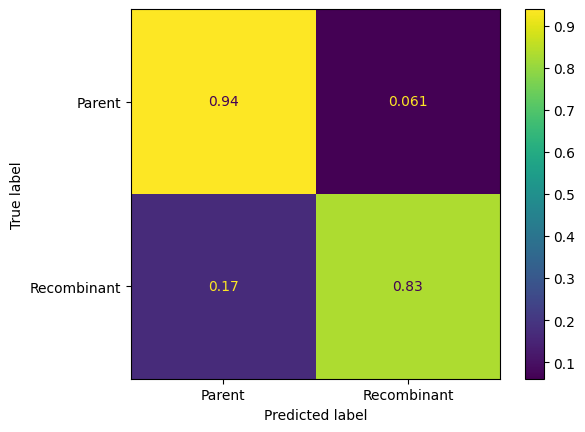

In [29]:
print("Evaluation on 'Unseen' test set")
preds =  neigh.predict(X_unseen)
# probs = probs[:, 1]
# y_preds = list(map(lambda x: 0 if x < 0.5 else 1, probs))
class_report(y_Unseen, preds)

### Decision Tree

In [ ]:
from sklearn import tree

descTree = tree.DecisionTreeClassifier()
descTree = descTree.fit(X_train, y_train)

In [ ]:
print("Evaluation on 'Unseen' test set")
preds =  descTree.predict(X_unseen)
# probs = probs[:, 1]
# y_preds = list(map(lambda x: 0 if x < 0.5 else 1, probs))
class_report(y_unseen, preds)

### SVM

In [ ]:
from sklearn import svm

svc = svm.SVC(
    max_iter=1000, 
    class_weight = class_weights,
    verbose=1,
    decision_function_shape= 'ovo')

svc.fit(X_train, y_train)

In [ ]:
print("Evaluation on 'Unseen' test set")
preds =  svc.predict(X_unseen)
# probs = probs[:, 1]
# y_preds = list(map(lambda x: 0 if x < 0.5 else 1, probs))
class_report(y_unseen, preds)